# Processamento de Linguagem Natural (PLN) e aprendizado não supervisionado aplicados às Leis do município de Curitiba

Implementação de PLN e de aprendizado não supervisionado (algoritmos de agrupamento) apresentada ao Centro de Ciências Matemáticas Aplicadas à Indústria do Instituto de Ciências Matemáticas e de Computação, Universidade de São Paulo - ICMC/USP, como parte dos requisitos para obtenção do título de Especialista em Ciências de Dados.

**Área de concentração**: Ciências de Dados

**Orientador**: Prof. Dr. Luis Gustavo Nonato\
**Aluno**: Luís Henrique Paiva

## 1 Aplicação do PLN

### 1.1 Instalação de bibliotecas

In [ ]:
%pip install spacy

In [ ]:
%python -m spacy download pt_core_news_sm
# !python -m spacy download pt_core_news_md
# !python -m spacy download pt_core_news_lg

In [ ]:
%pip install nltk

In [ ]:
%pip install gensim

In [ ]:
%pip install adjustText

In [ ]:
%pip install scikit-learn

In [ ]:
%pip install umap-learn

In [ ]:
%pip install hdbscan

### 1.2 Importação de bibliotecas

In [130]:
# Diversas
import pandas as pd
import numpy as np
import re
from collections import Counter

# PLN
import spacy
from spacy.lang.pt import stop_words
from spacy import displacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import umap

import hdbscan

from gensim.models import Word2Vec

# Visualização
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

from adjustText import adjust_text

from wordcloud import WordCloud

In [131]:
# Carregar o modelo do spacy para português
nlp = spacy.load("pt_core_news_sm")
# nlp = spacy.load("pt_core_news_md")
# nlp = spacy.load("pt_core_news_lg")

In [132]:
# Download dos pacotes da biblioteca NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Luis Henrique
[nltk_data]     Paiva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Luis Henrique
[nltk_data]     Paiva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Luis Henrique
[nltk_data]     Paiva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1.3 Criação do *DataFrame* para aplicação do PLN

In [ ]:
df = pd.read_csv('data/preprocessed/preprocessed.csv', sep='|', encoding='UTF-8')

### 1.4 Visualização e processamento dos dados

#### 1.4.1 Visualização dos dados antes do processamento

In [134]:
df.head(5)

ano  numeracao  \
0  2020    15797.0   
1  2020    15798.0   
2  2020    15779.0   
3  2020    15778.0   
4  2020    15780.0   

                                                                                                                                                                                                                                                                                               sumula  \
0                                                                                                                                        Altera dispositivos da Lei Municipal nº 15.669, de 3 de julho de 2020, que dispõe sobre as diretrizes para a elaboração da Lei Orçamentária Anual para 2021.   
1                                                                                                                                                                                                     Estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2021.   
2  Autoriza o Poder Executivo a constituir s o c i e d a d e p o r a ç õ e s , d e p r o p ó s i t o específico, com o objetivo de implantar, manter e operacionalizar uma Unidade Geradora a Biomassa e uma Unidade Geradora Fotovoltaica no Aterro Sanitário de Curitiba, e dá outras providências.   
3                                                                                                                                                                        Dispõe sobre a geração de energia elétrica f o t o v o l t a i c a n o s l a d o s d o s p a r q u e s m u n i c i p a i s .   
4                                                                                                                                                                                                                                                 Cria o Pólo Gastronômico e Cultural do Petit Batel.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 corpo_lei  
0  Art. 1º Ficam incluídas, alteradas e excluídas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei Municipal nº 15.669, de 3 de julho de 2020 - Lei de Diretrizes Orçamentárias para 2021, as ações discriminadas na forma do Anexo I, desta lei. Art. 2º Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º, e pelo inciso II, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei Municipal nº 15.669, de 2020. Art. 3º Fica alterado o Anexo de Avaliação Atuarial e Financeira do Sistema Previdenciário do Município, determinado pelo inciso IV, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constante na Lei Municipal nº 15.669, de 2020. Art. 4º Fica o Poder Executivo autorizado a repassar recursos a título de garantia, honra de avais, seguros e similares, autorizados por lei específica, incluídos na Lei Orçamentária Anual ou em seus créditos adicionais. ...  
1  TÍTULO I DAS DISPOSIÇÕES PRELIMINARES Art. 1º Esta lei estima a Receita e f

In [135]:
# 5 primeiros registro 2017
df[(df['ano'] == 2017)].head(5)

ano  numeracao  \
1317  2017    15157.0   
1318  2017    15155.0   
1319  2017    15156.0   
1320  2017    15152.0   
1321  2017    15153.0   

                                                                                                                                                   sumula  \
1317                                                      Estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2018.   
1318  Altera dispositivos da Lei nº 15.046, de 10 de julho de 2017, que dispõe sobre as diretrizes para a elaboração da Lei Orçamentária Anual para 2018.   
1319                                                                       Altera a redação do arts. 1° e 2° da Lei n° 15.124, de 29 de novembro de 2017.   
1320                         Altera e acrescenta dispositivos da Lei nº 9.626, de 8 de julho de 1999, e revoga a Lei nº 8.786, de 15 de dezembro de 1995.   
1321                                                           Dispõe sobre a criação do Comitê Municipal do Transporte Escolar no Município de Curitiba.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    corpo_lei  
1317  TÍTULO I DAS DISPOSIÇÕES PRELIMINARES Art. 1º Esta lei estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2018, compreendendo: I - Orçamento Fiscal, referente aos Poderes do Município, incluídos os órgãos e entidades da Administração Pública Municipal; II - Orçamento da Seguridade Social, composto pelas entidades e órgãos vinculados à saúde, à assistência social e à previdência; III - Orçamento de Investimento, o qual abrange as empresas em que o Município, direta ou indiretamente, detém a maioria do capital social com direito a voto. TÍTULO II DOS ORÇAMENTOS FISCAL E DA SEGURIDADE SOCIAL CAPÍTULO I DA ESTIMATIVA DA RECEITA Art. 2º A Receita Total dos Orçamentos Fiscal e da Seguridade Social é de R$ 7.673.000.000,00, decorrentes da arrecadação de tributos próprios e transferidos, contribuições e demais receitas correntes e de capital, na forma da legislação vigente e de acordo com cada orçamento: I - A Receita do Orçamento Fiscal é de R$ 6.195...  
1318                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Art. 1º Ficam incluídas, alteradas e excluídas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei nº 15.046, de 10 de julho de 2017 - Lei de Diretrizes Orçamentárias para 2018, as ações discriminadas na forma do Anexo I, desta lei. Art. 2º. Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º e pelo inciso II do § 2º do art. 4º da Lei Complementar Federal nº 101, de 4 de ma

In [136]:
# 5 primeiros registro 2018
df[(df['ano'] == 2018)].head(5)

ano  numeracao  \
352  2018    15374.0   
353  2018    15375.0   
354  2018    15369.0   
355  2018    15370.0   
356  2018    15372.0   

                                                                                                                                                                                  sumula  \
352                         Altera dispositivos da Lei Municipal nº 15.269, de 6 de julho de 2018, que dispõe sobre as diretrizes para a elaboração da Lei Orçamentária Anual para 2019.   
353                                                                                        Estima a Receita e fixa Despesa do Município de Curitiba para o exercício financeiro de 2019.   
354  Denomina de CLOTILDE DE LOURDES BRANCO GERMINIANI - PROFESSORA C L O T I L D E D E L O U R D E S B R A N C O GERMINIANI, um dos logradouros públicos da Capital ainda não nominado.   
355                                                    Declara de Utilidade Pública a ACEPP - ONG Assistencial a Crianças Carentes Portadoras com Câncer, Leucemia e Paralisia Cerebral.   
356                                                                                                                                Declara de Utilidade Pública o Maestro Esporte Clube.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   corpo_lei  
352                                                                                                                                                                                         Art. 1º Ficam incluídas, alteradas e excluídas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei nº 15.269, de 6 de julho de 2018 - Lei de Diretrizes Orçamentárias para 2019, as ações discriminadas na forma do Anexo I, desta lei. Art. 2º Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º, e pelo inciso II, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei nº 15.269, de 2018. Art. 3º Fica alterado e atualizado o Anexo de Avaliação Atuarial e Financeira do Sistema Previdenciário do Município, determinado pelo inciso IV, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constante na Lei nº 15.269, de 2018. Art. 4º Esta lei entra em vigor na data de sua publicação.  
353  TÍTULO I DAS DISPOSIÇÕES PRELIMINARES Art. 1º. Esta lei estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2019, compreendendo: I - Orçamento Fiscal, referente aos Poderes do Município, incluídos os órgãos e entidades da Administração Pública Municipal; II - Orçamento da Seguridade Social, composto pelas entidades e órgãos vinculados à saúde, à assistência social e à previdência; III - Orçamento de Investimento, o qual abrange as empresas em que o Município, direta ou indiretamente, detém a maioria do capital social com direito a voto. TÍTULO II DOS ORÇAMENTOS FISCAL E DA SEGURIDADE SOCIAL CAPÍTULO I DA ESTIMATIVA DA RECEITA Art. 2º. A Receita Total dos Orçamentos F

In [137]:
# 5 primeiros registro 2019
df[(df['ano'] == 2019)].head(5)

ano  numeracao  \
568  2019    15586.0   
569  2019    15585.0   
570  2019    15587.0   
571  2019    15578.0   
572  2019    15580.0   

                                                                                                                                                                                                                                                                                                                                                     sumula  \
568                                                                                                                                                                                            Altera dispositivos da Lei Municipal nº 15.469, de 5 de julho de 2019, que dispõe sobre as diretrizes para a elaboração da Lei Orçamentária Anual para 2020.   
569                                                                                                                                                                                                           Dispõe sobre a proibição da queima, soltura e manuseio de fogos de artifício e artefatos pirotécnicos de alto impacto ou com efeitos de tiro.   
570                                                                                                                                                                                                                                                         Estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2020.   
571  D i s p õ e s o b r e a a b e r t u r a d e C r é d i t o Adicional Especial e Suplementar, no valor de R$ 140.278.000,00 (cento e quarenta milhões, duzentos e setenta e oito mil reais), d e s t i n a d o s a a t e n d e r d e s p e s a s c o m execução de serviços de manutenção, desapropriação para aquisição de imóvel e aumento de capital.   
572                                                                                                                                                                                                                                                                                             Concede o Título de Vulto Emérito de Curitiba a Rosa Osaki.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   corpo_lei  
568  Art. 1º Ficam incluídas, alteradas e excluídas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei Municipal nº 15.469, de 5 de julho de 2019 - Lei de Diretrizes Orçamentárias para 2020, as ações discriminadas na forma do Anexo I, desta lei. Art. 2º Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º, e pelo inciso II, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei Municipal nº 15.469, de 2019. Art. 3º Ficam incluídos/alterados, de acordo com o inciso III, § 2º do art. 125, da Lei Orgânica do Município e o art. 6º, da Lei Municipal nº 15.131, de 2017, Plano Plurianual 2018-2021, os programas abaixo discriminados: I -

In [138]:
# 5 primeiros registro 2020
df[(df['ano'] == 2020)].head(5)

ano  numeracao  \
0  2020    15797.0   
1  2020    15798.0   
2  2020    15779.0   
3  2020    15778.0   
4  2020    15780.0   

                                                                                                                                                                                                                                                                                               sumula  \
0                                                                                                                                        Altera dispositivos da Lei Municipal nº 15.669, de 3 de julho de 2020, que dispõe sobre as diretrizes para a elaboração da Lei Orçamentária Anual para 2021.   
1                                                                                                                                                                                                     Estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2021.   
2  Autoriza o Poder Executivo a constituir s o c i e d a d e p o r a ç õ e s , d e p r o p ó s i t o específico, com o objetivo de implantar, manter e operacionalizar uma Unidade Geradora a Biomassa e uma Unidade Geradora Fotovoltaica no Aterro Sanitário de Curitiba, e dá outras providências.   
3                                                                                                                                                                        Dispõe sobre a geração de energia elétrica f o t o v o l t a i c a n o s l a d o s d o s p a r q u e s m u n i c i p a i s .   
4                                                                                                                                                                                                                                                 Cria o Pólo Gastronômico e Cultural do Petit Batel.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 corpo_lei  
0  Art. 1º Ficam incluídas, alteradas e excluídas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei Municipal nº 15.669, de 3 de julho de 2020 - Lei de Diretrizes Orçamentárias para 2021, as ações discriminadas na forma do Anexo I, desta lei. Art. 2º Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º, e pelo inciso II, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei Municipal nº 15.669, de 2020. Art. 3º Fica alterado o Anexo de Avaliação Atuarial e Financeira do Sistema Previdenciário do Município, determinado pelo inciso IV, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constante na Lei Municipal nº 15.669, de 2020. Art. 4º Fica o Poder Executivo autorizado a repassar recursos a título de garantia, honra de avais, seguros e similares, autorizados por lei específica, incluídos na Lei Orçamentária Anual ou em seus créditos adicionais. ...  
1  TÍTULO I DAS DISPOSIÇÕES PRELIMINARES Art. 1º Esta lei estima a Receita e f

In [139]:
# 5 primeiros registro 2021
df[(df['ano'] == 2021)].head(5)

ano  numeracao  \
209  2021    15942.0   
210  2021    15940.0   
211  2021    15941.0   
212  2021    15938.0   
213  2021    15939.0   

                                                                                                                                                                                                                                                                                                                                           sumula  \
209  Altera a Lei nº 15. 799, de 05 de janeiro de 2 0 2 1 q u e " d i s p õ e s o b r e i n f r a ç õ e s administrativas derivadas de condutas e atividades lesivas ao enfrentamento da emergência de saúde pública de importância i n t e r n a c i o n a l d e c o r r e n t e d o n o v o Coronavírus - Covid-19 - e dá outras providências".   
210                                                                                                                                                                                                                                               Estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2022.   
211                                                                                                                                                                                                                                Denomina de Saionara Aparecida da Silveira Galacho, um dos logradouros públicos da Capital ainda não nominado.   
212                                                                                                                                                                                           Altera dispositivos da Lei nº 15.855, de 1º de julho de 2021, que dispõe sobre as diretrizes para a elaboração da Lei Orçamentária Anual para 2022.   
213                                                                                                                                                                                                                                          Autoriza o Poder Executivo a adquirir da URBS - Urbanização de Curitiba S.A as áreas que especifica.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   corpo_lei  
209                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Art. 1º Acrescenta o § 2º ao art. 12 da Lei nº 15.799, de 2021, com a seguinte redação: "Art. 12. (...) § 2º Ficam postergados até o dia 31/12/2022, os pagamentos das multas pecuniárias aplicadas até o dia 10 de dezembro

In [140]:
# 5 primeiros registro 2022
df[(df['ano'] == 2022)].head(5)

ano  numeracao  \
780  2022    16115.0   
781  2022    16116.0   
782  2022    16108.0   
783  2022    16109.0   
784  2022    16110.0   

                                                                                                                                                                                                sumula  \
780                                      Altera dispositivos da Lei Municipal nº 16.036, de 30 de junho de 2022, que dispõe sobre as diretrizes para a elaboração da Lei Orçamentária Anual para 2023.   
781                                                                                                    Estima a receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2023.   
782                                                                                                                     Concede o título de Cidadã Honorária de Curitiba à Sra. Tathiana Laiz Guzella.   
783  Declara de Utilidade Pública a Associação de Pais, Mestres e Funcionários (APMF) da instituição de ensino do Colégio Estadual Padre Cláudio Morelli (APM da Escola Estadual Pr. Cláudio Morelli).   
784                                                                                                                         Concede o título de Vulto Emérito de Curitiba ao Sr. Carlos Antônio Gusso.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   corpo_lei  
780  Art. 1º. Ficam incluídas e alteradas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei Municipal nº 16.036, de 30 de junho de 2022 - Lei de Diretrizes Orçamentárias para 2023, as ações discriminadas na forma do Anexo I, desta lei. Art. 2º. Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º, e pelo inciso II, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei Municipal nº 16.036, de 2022. Art. 3º. Fica incluída no quadro “Ações Orçamentárias” do Plano Plurianual 2022-2025, Lei Municipal nº 15.926, de 13 de dezembro de 2021, a ação discriminada abaixo, no seu respectivo programa, de acordo com o inciso III, do § 2º, do art. 125, da Lei Orgânica do Município: 0006 - PROGRAMA VIVA CURITIBA MAIS ÁGIL AÇÃO ORÇAMENTÁRIA DESCRIÇÃO ÓRGÃO EXECUTOR 2264 APORTE PARA O EQUILIBRIO TARIFÁRIO FUC PPA COMPATIBILIDADE 7.4.1 Planejamento Urbano em Mobilidade 7.4.3 Transporte Art. 4º Es...  
781  TÍTULO I DAS DISPOSIÇÕES PRELIMINARES Art. 1º. Esta lei estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2023, compreendendo: I - Orçamento Fiscal, referente aos Poderes do Município, incluídos os órgãos e entidades da Administração Pública Municipal; II - Orçamento da Seguridade Social, composto pelas entidades e órgãos vinculados à saúde, à assistência social e à previdência; III - Orçamento de Investimento, o qual abrange as empresas em que o Município, direta ou indiretamente, detém a maioria do capital social com direito a voto. TÍTULO II DOS ORÇAMENTOS FISCAL E DA SEGURIDADE 

In [141]:
# 5 primeiros registro 2023
df[(df['ano'] == 2023)].head(5)

ano  numeracao  \
954  2023    16278.0   
955  2023    16279.0   
956  2023    16283.0   
957  2023    16282.0   
958  2023    16276.0   

                                                                                                                                                                                                                                                  sumula  \
954                                                                                                                                                               Institui a Política de Transparência em Obras Públicas (TOP) do Município de Curitiba.   
955                                                                                                                                                                          Declara de Utilidade Pública a Instituição Religiosa de Umbanda Vovó Benta.   
956                                                                                                                                                                                   Institui a Política Municipal de Incentivo a Cursinhos Solidários.   
957                                                                                                                                                                                          Institui o Documento de Identificação da Pessoa com Câncer.   
958  Acrescenta arts. 6º-A, 6º-B e 6º-C à Lei nº 12.597, de 17 de janeiro de 2008, que "dispõe sobre a organização do Sistema de Transporte Coletivo da Cidade de Curitiba, autoriza o Poder Público a delegar a sua execução e dá outras providências”.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   corpo_lei  
954  Art. 1º Fica instituída a Política de Transparência em Obras Públicas (TOP) do Município de Curitiba. Parágrafo único. A política municipal de que trata esta Lei atenderá às orientações expedidas pelos órgãos responsáveis pela gestão e coordenação do Portal de Transparência do Município de Curitiba, nos termos dos regulamentos próprios. Art. 2º São consideradas, para aplicação desta Lei, as definições de obra e de serviço previstas na Lei Federal nº 14.133, de 1º de abril de 2021, em seu art. 6º, inc. XI e XII. § 1º A publicidade de informações sobre execução de obras, serviços de engenharia e/ou arquitetura, como definidos em regulamento municipal, será disponibilizada para consulta no Painel de Obras do Município de Curitiba. § 2º As disposições desta Lei também se aplicam às obras e serviços de engenharia oriundos de convênios firmados pela Administração Municipal. Art. 3º São objetivos da política instituída por esta Lei: I - estabelecer uma relação cooperativa entre a administ...  
955                                                                                                                                                                                                                                                                                                                                           

In [142]:
# 5 primeiros registro 2024
df[(df['ano'] == 2024)].head(5)

ano  numeracao  \
1112  2024    16483.0   
1113  2024    16482.0   
1114  2024    16466.0   
1115  2024    16467.0   
1116  2024    16468.0   

                                                                                                                                                               sumula  \
1112                                                                  Estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2025.   
1113  Altera dispositivos da Lei Municipal nº 16.362, de 28 de junho de 2024, que "dispõe sobre as diretrizes para a elaboração da Lei Orçamentária Anual para 2025".   
1114                            Dispõe sobre o processo administrativo, no âmbito da Administração Pública Direta, Autárquica e Fundacional do Município de Curitiba.   
1115                                                                    Declara de Utilidade Pública o Conselho de Ministros Evangélicos do Estado do Paraná - COMEP.   
1116                           Institui no Calendário Oficial do Município o dia do Rally da Inclusão, a ser comemorado, anualmente, na semana do dia 21 de setembro.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    corpo_lei  
1112  TÍTULO I DAS DISPOSIÇÕES PRELIMINARES Art. 1º. Esta lei estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2025, compreendendo: I - Orçamento Fiscal, referente aos Poderes do Município, incluídos os órgãos e entidades da Administração Pública Municipal; II - Orçamento da Seguridade Social, composto pelas entidades e órgãos vinculados à saúde, à assistência social e à previdência; III - Orçamento de Investimento, o qual abrange as empresas em que o Município, direta ou indiretamente, detém a maioria do capital social com direito a voto. TÍTULO II DOS ORÇAMENTOS FISCAL E DA SEGURIDADE SOCIAL CAPÍTULO I DA ESTIMATIVA DA RECEITA Art. 2º. A Receita Total dos Orçamentos Fiscal e da Seguridade Social é de R$ 12.742.000.000,00, decorrentes da arrecadação de tributos próprios e transferidos, contribuições e demais receitas correntes e de capital, na forma da legislação vigente e de acordo com cada orçamento: I - A Receita do Orçamento Fiscal é de R$ 10...  
1113  Art. 1º Ficam incluídas/alteradas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei Municipal nº 16.362, de 28 de junho de 2024 - Lei de Diretrizes Orçamentárias para 2025, as ações discriminadas na forma do Anexo I, desta lei. Art. 2º Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º e pelo inciso II do § 2º do art. 4º da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei nº 16.362, de 2024. Art. 3º Ficam incluídas no quadro “Ações Orçamentárias” do Plano Plurianual 2022-2025, Lei Municipal nº 15.926, de 13 de dezembro de 2021, as ações discriminadas abaixo, nos seus respectivos programas, de acordo com o inciso III, do § 2º, do art. 125, da Lei Orgânica do Município: 0001 - PROGRAMA VIVA CURITIBA QUE NÃO DORME AÇÃ

#### 1.4.2 Processamento de texto

In [143]:
def processa_texto(texto):
    if isinstance(texto, str):
        # Converter para minúsculas
        texto = texto.lower()

        # Remover números seguidos de símbolos ordinais (1º, 2°, 3ª, ...)
        texto = re.sub(r'\d+[°ºª]', '', texto)

        # Remover números (0-9) isolados
        texto = re.sub(r'\d+', '', texto)

        # Remover símbolos ordinais isolados (°, º, ª)
        texto = re.sub(r'[°ºª]', '', texto)

        # Remover os vinte primeiros números romanos (i a xx)
        numeros_romanos = [
            r'\bxx\b', r'\bxix\b', r'\bxviii\b', r'\bxvii\b', r'\bxvi\b',
            r'\bxv\b', r'\bxiv\b', r'\bxiii\b', r'\bxii\b', r'\bxi\b',
            r'\bx\b', r'\bix\b', r'\bviii\b', r'\bvii\b', r'\bvi\b',
            r'\bv\b', r'\biv\b', r'\biii\b', r'\bii\b', r'\bi\b'
        ]
        for romano in numeros_romanos:
            texto = re.sub(romano, '', texto)

        # Remover pontuação e caracteres especiais
        texto = re.sub(r'[^\w\s]', '', texto)

        # Remover espaços múltiplos
        texto = re.sub(r'\s+', ' ', texto).strip()

        return texto
    else:
        return ''

In [144]:
df['lei_processada'] = df['corpo_lei'].apply(processa_texto)

In [145]:
df['lei_processada'].head(5)

0    art ficam incluídas alteradas e excluídas no anexo das metas e prioridades da administração municipal aprovado na lei municipal n de de julho de lei de diretrizes orçamentárias para as ações discriminadas na forma do anexo desta lei art ficam atualizados os valores dos quadros do anexo de metas fiscais determinados pelo e pelo inciso do do art da lei complementar federal n de de maio de constantes na lei municipal n de art fica alterado o anexo de avaliação atuarial e financeira do sistema previdenciário do município determinado pelo inciso do do art da lei complementar federal n de de maio de constante na lei municipal n de art fica o poder executivo autorizado a repassar recursos a título de garantia honra de avais seguros e similares autorizados por lei específica incluídos na lei orçamentária anual ou em seus créditos adicionais parágrafo único os repasses de recursos serão efetivados mediante termos de parceria colaboração ou termos afins conforme determinam o art da lei fede

In [146]:
# Comparação do texto antes e depois do processamento
print("Texto original:")
print(df['corpo_lei'][0])
print("\nTexto pré-processado:")
print(df['lei_processada'][0])

Texto original:
Art. 1º Ficam incluídas, alteradas e excluídas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei Municipal nº 15.669, de 3 de julho de 2020 - Lei de Diretrizes Orçamentárias para 2021, as ações discriminadas na forma do Anexo I, desta lei. Art. 2º Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º, e pelo inciso II, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei Municipal nº 15.669, de 2020. Art. 3º Fica alterado o Anexo de Avaliação Atuarial e Financeira do Sistema Previdenciário do Município, determinado pelo inciso IV, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constante na Lei Municipal nº 15.669, de 2020. Art. 4º Fica o Poder Executivo autorizado a repassar recursos a título de garantia, honra de avais, seguros e similares, autorizados por lei específica, incluídos na Lei Orçamentária Anual ou em seus créditos 

#### 1.4.3 Processamento de sentenças

#### 1.4.3.1 Métricas de senteças no texto

In [147]:
def segmenta_sentencas(texto):
    # Verifica se o texto é uma string
    if isinstance(texto, str):
        # Segmenta as sentenças
        doc = nlp(texto)
        return [sent.text for sent in doc.sents]
    else:
        return []

In [148]:
df['sentencas'] = df['corpo_lei'].apply(segmenta_sentencas)

In [149]:
df['sentencas']

0       [Art. 1º Ficam incluídas, alteradas e excluídas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei Municipal nº 15.669, de 3 de julho de 2020 - Lei de Diretrizes Orçamentárias para 2021, as ações discriminadas na forma do Anexo I, desta lei., Art. 2º Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º, e pelo inciso II, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei Municipal nº 15.669, de 2020., Art. 3º Fica alterado o Anexo de Avaliação Atuarial e Financeira do Sistema Previdenciário do Município, determinado pelo inciso IV, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constante na Lei Municipal nº 15.669, de 2020., Art. 4º Fica o Poder Executivo autorizado a repassar recursos a título de garantia, honra de avais, seguros e similares, autorizados por lei específica, incluídos na Lei Orçamentária Anual ou em seus créditos adic

In [150]:
df['sentencas'][0]

['Art. 1º Ficam incluídas, alteradas e excluídas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei Municipal nº 15.669, de 3 de julho de 2020 - Lei de Diretrizes Orçamentárias para 2021, as ações discriminadas na forma do Anexo I, desta lei.',
 'Art. 2º Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º, e pelo inciso II, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei Municipal nº 15.669, de 2020.',
 'Art. 3º Fica alterado o Anexo de Avaliação Atuarial e Financeira do Sistema Previdenciário do Município, determinado pelo inciso IV, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constante na Lei Municipal nº 15.669, de 2020.',
 'Art. 4º Fica o Poder Executivo autorizado a repassar recursos a título de garantia, honra de avais, seguros e similares, autorizados por lei específica, incluídos na Lei Orçamentária Anual ou em seus créditos ad

In [151]:
len(df['sentencas'][0])

12

In [152]:
def media_sentencas(df, coluna):
    # Verifica o tamanho de cada lista na coluna e calcula a média
    num_itens = df[coluna].apply(len)
    return num_itens.mean()

In [153]:
print(media_sentencas(df, 'sentencas'))

15.473936899862826


In [154]:
def mediana_sentencas(df, coluna):
    # Verifica o tamanho de cada lista na coluna e calcula a mediana
    num_itens = df[coluna].apply(len)
    return num_itens.median()

In [155]:
print(mediana_sentencas(df, 'sentencas'))

5.0


##### 1.4.3.2 Métricas do comprimento de sentenças

In [156]:
def comprimento_medio_sentencas(coluna):
    def contar_palavras(sentencas):
        # Conta o número de palavras em cada sentença
        return [len(sentenca.split()) for sentenca in sentencas]

    # Aplica a função para contar as palavras em cada célula da coluna
    palavras_por_sentenca = coluna.apply(contar_palavras)

    # Agora calcula a média de palavras por sentença para cada linha
    media_palavras = palavras_por_sentenca.apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)

    return media_palavras

In [157]:
df['comprimento'] = comprimento_medio_sentencas(df['sentencas'])

In [158]:
df[['numeracao', 'ano', 'comprimento']].nlargest(n=10, columns=['comprimento'])

numeracao   ano  comprimento
692     15468.0  2019   231.166667
968     16261.0  2023   126.688889
1330    15143.0  2017    99.469388
147     15650.0  2020    95.500000
440     15283.0  2018    89.631579
285     15863.0  2021    85.454545
769     15387.0  2019    83.800000
713     15443.0  2019    80.888889
213     15939.0  2021    74.500000
1262    16336.0  2024    74.250000

In [159]:
df[['numeracao', 'ano', 'comprimento']].nsmallest(n=10, columns=['comprimento'])

numeracao   ano  comprimento
846     16051.0  2022     5.000000
1094    16139.0  2023     5.285714
307     15843.0  2021     5.333333
630     15529.0  2019     5.333333
604     15549.0  2019     5.375000
112     15677.0  2020     5.400000
1177    16420.0  2024     5.600000
574     15581.0  2019     5.750000
368     15359.0  2018     5.800000
529     15199.0  2018     6.000000

In [160]:
df['comprimento'].mean()

16.090207014438157

In [161]:
df['comprimento'].median()

12.2

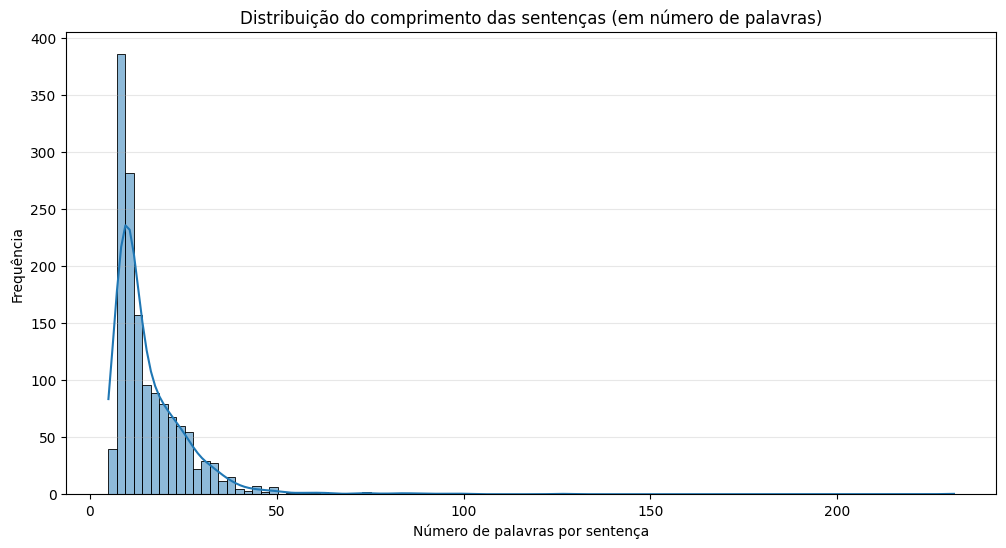

In [162]:
plt.figure(figsize=(12, 6))

sns.histplot(df['comprimento'], bins=100, kde=True)
plt.title('Distribuição do comprimento das sentenças (em número de palavras)')
plt.xlabel('Número de palavras por sentença')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.3)

plt.show()

In [163]:
df[df['comprimento'].between(0, 50, inclusive='both')].count()

ano               1440
numeracao         1439
sumula            1440
corpo_lei         1440
lei_processada    1440
sentencas         1440
comprimento       1440
dtype: int64

In [164]:
df[df['comprimento'].between(50, 100, inclusive='right')].count()

ano               16
numeracao         16
sumula            16
corpo_lei         16
lei_processada    16
sentencas         16
comprimento       16
dtype: int64

In [165]:
df[df['comprimento'].between(100, 3000, inclusive='right')].count()

ano               2
numeracao         2
sumula            2
corpo_lei         2
lei_processada    2
sentencas         2
comprimento       2
dtype: int64

#### 1.4.4 Processamento das palavras

##### 1.4.4.1 *Tokenização*, *Stop Words* e *Lematização*

In [166]:
def tokenizar_stopwords_lematizar(texto, nlp=nlp):
    doc = nlp(texto)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop
        and not token.is_punct
        and not token.is_space
    ]
    return tokens

In [167]:
df['tokens'] = df['lei_processada'].apply(tokenizar_stopwords_lematizar)

In [168]:
df['tokens'][0]

['art',
 'ficar',
 'incluído',
 'alterar',
 'excluír',
 'anexo',
 'meta',
 'prioridade',
 'administração',
 'municipal',
 'aprovar',
 'lei',
 'municipal',
 'n',
 'julho',
 'lei',
 'diretriz',
 'orçamentária',
 'ação',
 'discriminar',
 'anexo',
 'lei',
 'art',
 'ficar',
 'atualizado',
 'valor',
 'quadro',
 'anexo',
 'meta',
 'fiscal',
 'determinar',
 'inciso',
 'art',
 'lei',
 'complementar',
 'federal',
 'n',
 'maio',
 'constante',
 'lei',
 'municipal',
 'n',
 'art',
 'ficar',
 'alterar',
 'anexo',
 'avaliação',
 'atuarial',
 'financeiro',
 'previdenciário',
 'município',
 'determinar',
 'inciso',
 'art',
 'lei',
 'complementar',
 'federal',
 'n',
 'maio',
 'constante',
 'lei',
 'municipal',
 'n',
 'art',
 'ficar',
 'executivo',
 'autorizar',
 'repassar',
 'recurso',
 'título',
 'garantia',
 'honra',
 'aval',
 'seguro',
 'similar',
 'autorizar',
 'lei',
 'específico',
 'incluir',
 'lei',
 'orçamentário',
 'anual',
 'crédito',
 'adicional',
 'parágrafo',
 'único',
 'repasse',
 'recurso'

In [169]:
df['tokens'][:10]

0                                                                                                                                                               [art, ficar, incluído, alterar, excluír, anexo, meta, prioridade, administração, municipal, aprovar, lei, municipal, n, julho, lei, diretriz, orçamentária, ação, discriminar, anexo, lei, art, ficar, atualizado, valor, quadro, anexo, meta, fiscal, determinar, inciso, art, lei, complementar, federal, n, maio, constante, lei, municipal, n, art, ficar, alterar, anexo, avaliação, atuarial, financeiro, previdenciário, município, determinar, inciso, art, lei, complementar, federal, n, maio, constante, lei, municipal, n, art, ficar, executivo, autorizar, repassar, recurso, título, garantia, honra, aval, seguro, similar, autorizar, lei, específico, incluir, lei, orçamentário, anual, crédito, adicional, parágrafo, único, repasse, recurso, ser, efetivar, mediante, termos, parceria, colaboração, termo, afim, conforme, determinar, art, lei, 

In [170]:
df['contagem_tokens'] = df['tokens'].apply(lambda x: len(x))

In [171]:
df['contagem_tokens']

0       154
1       970
2       545
3        27
4        69
       ... 
1453     14
1454     92
1455     15
1456     47
1457    359
Name: contagem_tokens, Length: 1458, dtype: int64

In [172]:
df['contagem_tokens'].sum()

247119

In [173]:
df[['numeracao', 'ano', 'contagem_tokens']].nlargest(n=10, columns=['contagem_tokens'])

numeracao   ano  contagem_tokens
645     15511.0  2019             9304
295     15852.0  2021             8228
1034    16203.0  2023             4942
1033    16202.0  2023             4547
1029    16198.0  2023             4366
865     16036.0  2022             4238
1233    16362.0  2024             3875
1032    16201.0  2023             3868
298     15855.0  2021             3786
128     15669.0  2020             3697

In [174]:
df[['numeracao', 'ano', 'contagem_tokens']].nsmallest(n=10, columns=['contagem_tokens'])

numeracao   ano  contagem_tokens
85     15713.0  2020               12
142    15666.0  2020               12
149    15645.0  2020               12
161    15643.0  2020               12
203    15598.0  2020               12
251    15897.0  2021               12
280    15870.0  2021               12
401    15343.0  2018               12
428    15301.0  2018               12
455    15273.0  2018               12

In [175]:
df['contagem_tokens'].mean()

169.4917695473251

In [176]:
df['contagem_tokens'].median()

32.0

##### 1.4.4.2 Contagem e frequência de palavras

In [177]:
def contar_palavras(df, coluna, excluir_palavras=None):
    if excluir_palavras is None:
        excluir_palavras = set()

    # Juntar todas as palavras de todas as listas da coluna
    # Ignora em caso de palavras a serem desconsideradas
    palavras = []

    for lista in df[coluna]:
        for palavra in lista:
            # Adiciona a palavra apenas se não estiver na lista de exclusão
            if palavra.strip() and palavra not in excluir_palavras and not palavra.isdigit():
                palavras.append(palavra)

    # Contar as ocorrências de cada palavra
    contagem_palavras = Counter(palavras)

    return contagem_palavras

In [178]:
todas_palavras = contar_palavras(df, 'tokens')
print(todas_palavras)

Counter({'art': 9055, 'lei': 5808, 'municipal': 4178, 'n': 3402, 'ser': 2722, 'público': 2379, 'curitiba': 2303, 'data': 1781, 'município': 1648, 'publicação': 1632, 'ficar': 1485, 'vigor': 1475, 'entrar': 1462, 'r': 1232, 'seguinte': 1228, 'm': 1193, 'metro': 1163, 'recurso': 1129, 'lote': 1081, 'fiscal': 1044, 'administração': 1026, 'federal': 1004, 'prefeitura': 979, 'imóvel': 975, 'rua': 967, 'único': 966, 'social': 939, 'parágrafo': 914, 'executivo': 913, 'conforme': 890, 'artigo': 889, 'orçamentário': 881, 'avaliação': 841, 'despesa': 816, 'secretaria': 791, 'prever': 789, 'inciso': 777, 'cargo': 764, 'órgão': 752, 'serviço': 714, 'servidor': 705, 'ação': 680, 'fundo': 672, 'dia': 668, 'caput': 655, 'atividade': 654, 'procedimento': 645, 'medir': 641, 'uso': 640, 'direito': 635, 'autorizar': 633, 'programa': 622, 'orçamento': 606, 'estabelecer': 582, 'crédito': 578, 'especial': 575, 'redação': 571, 'receita': 523, 'indicação': 520, 'respectivo': 519, 'gestão': 518, 'complementar'

In [179]:
palavras_mais_frequentes = todas_palavras.most_common(10)
print("Top 10 palavras mais frequentes:", palavras_mais_frequentes)

Top 10 palavras mais frequentes: [('art', 9055), ('lei', 5808), ('municipal', 4178), ('n', 3402), ('ser', 2722), ('público', 2379), ('curitiba', 2303), ('data', 1781), ('município', 1648), ('publicação', 1632)]


In [180]:
# Mesclagem de 'm' e 'metro', pois possuem o mesmo valor semântico
df['tokens'] = df['tokens'].apply(lambda tokens: [token.replace('m', 'metro') if token == 'm' else token for token in tokens])

In [181]:
# Mesclagem de 'n' e 'número', pois possuem o mesmo valor semântico
df['tokens'] = df['tokens'].apply(lambda tokens: [token.replace('n', 'número') if token == 'n' else token for token in tokens])

In [182]:
# Troca de 'r' por 'brl', para melhor significação da moeda brasileira
df['tokens'] = df['tokens'].apply(lambda tokens: [token.replace('r', 'brl') if token == 'r' else token for token in tokens])

In [183]:
df['tokens'][:10]

0                                                                                                                                      [art, ficar, incluído, alterar, excluír, anexo, meta, prioridade, administração, municipal, aprovar, lei, municipal, número, julho, lei, diretriz, orçamentária, ação, discriminar, anexo, lei, art, ficar, atualizado, valor, quadro, anexo, meta, fiscal, determinar, inciso, art, lei, complementar, federal, número, maio, constante, lei, municipal, número, art, ficar, alterar, anexo, avaliação, atuarial, financeiro, previdenciário, município, determinar, inciso, art, lei, complementar, federal, número, maio, constante, lei, municipal, número, art, ficar, executivo, autorizar, repassar, recurso, título, garantia, honra, aval, seguro, similar, autorizar, lei, específico, incluir, lei, orçamentário, anual, crédito, adicional, parágrafo, único, repasse, recurso, ser, efetivar, mediante, termos, parceria, colaboração, termo, afim, conforme, determinar, art, lei, 

In [184]:
# Desconsiderando palavras que fazem parte da estrutura das leis
palavras_excluir = {'art', 'artigo', 'caput', 'parágrafo',
                    'único', 'inciso', 'alínea', ' '}

In [185]:
def limpar_tokens(texto, palavras_excluir):
    tokens_limpos = [token for token in texto if token not in palavras_excluir]
    return tokens_limpos

In [186]:
df['tokens_limpos'] = df['tokens'].apply(lambda x: limpar_tokens(x, palavras_excluir))

In [187]:
df['tokens_limpos'][:10]

0                                                                                                 [ficar, incluído, alterar, excluír, anexo, meta, prioridade, administração, municipal, aprovar, lei, municipal, número, julho, lei, diretriz, orçamentária, ação, discriminar, anexo, lei, ficar, atualizado, valor, quadro, anexo, meta, fiscal, determinar, lei, complementar, federal, número, maio, constante, lei, municipal, número, ficar, alterar, anexo, avaliação, atuarial, financeiro, previdenciário, município, determinar, lei, complementar, federal, número, maio, constante, lei, municipal, número, ficar, executivo, autorizar, repassar, recurso, título, garantia, honra, aval, seguro, similar, autorizar, lei, específico, incluir, lei, orçamentário, anual, crédito, adicional, repasse, recurso, ser, efetivar, mediante, termos, parceria, colaboração, termo, afim, conforme, determinar, lei, federal, número, alteração, lei, complementar, número, lrf, unidade, orçamentário, custear, contribuição, 

In [188]:
todas_palavras_sem_estrutura = contar_palavras(df, 'tokens_limpos', palavras_excluir)

In [189]:
# Top 10 palavras mais frequentes
palavras_mais_frequentes_sem_estrutura = todas_palavras_sem_estrutura.most_common(10)
palavras_mais_frequentes_sem_estrutura

[('lei', 5808),
 ('municipal', 4178),
 ('número', 3402),
 ('ser', 2722),
 ('público', 2379),
 ('metro', 2356),
 ('curitiba', 2303),
 ('data', 1781),
 ('município', 1648),
 ('publicação', 1632)]

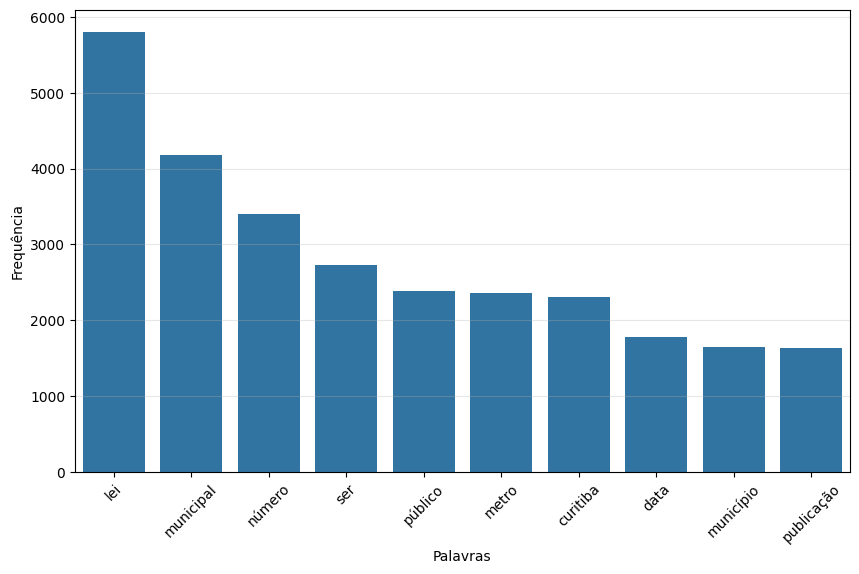

In [190]:
palavras, contagem = zip(*palavras_mais_frequentes_sem_estrutura)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(palavras), y=list(contagem))

#plt.title('Distribuição das 10 palavras mais frequentes, desconsiderando estruturais')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.show()

In [191]:
tema_politicas = {'agricultura', 'alimentação', 'ambiente', 'cultura',
             'educação', 'habitação', 'igualdade', 'justiça', 'saneamento',
             'saúde','segurança', 'tecnologia', 'trabalho', 'transporte'}

politicas = []

for lista in df['tokens_limpos']:
    for politica in lista:
        # Adiciona a palavra apenas se não estiver na lista de exclusão
        if politica.strip() and politica in tema_politicas:
            politicas.append(politica)

    contagem_politicas = Counter(politicas)

contagem_politicas

Counter({'saúde': 471,
         'educação': 359,
         'ambiente': 265,
         'trabalho': 255,
         'tecnologia': 183,
         'segurança': 182,
         'transporte': 182,
         'habitação': 149,
         'saneamento': 75,
         'alimentação': 70,
         'cultura': 45,
         'justiça': 28,
         'agricultura': 27,
         'igualdade': 26})

In [192]:
# Extendendo os temas
politicas_palavras_chave = {
    'agricultura': ['agricultura', 'campo', 'agronegócio', 'produtores rurais', 'colheita'],
    'alimentação': ['alimentação', 'nutrição', 'comida', 'dietas', 'saúde alimentar'],
    'ambiente': ['meio ambiente', 'natureza', 'poluição', 'sustentabilidade', 'ecologia'],
    'cultura': ['cultura', 'arte', 'música', 'dança', 'teatro', 'literatura'],
    'educação': ['educação', 'ensino', 'escola', 'universidade', 'professor', 'aluno'],
    'habitação': ['habitação', 'moradia', 'casa', 'imóveis', 'aluguel'],
    'igualdade': ['igualdade', 'direitos humanos', 'equidade', 'discriminação', 'justiça social'],
    'justiça': ['justiça', 'tribunal', 'processo', 'direitos', 'juiz', 'sentença'],
    'saneamento': ['saneamento', 'água potável', 'esgoto', 'higiene', 'despoluição'],
    'saúde': ['saúde', 'hospital', 'medicina', 'tratamento', 'doença', 'sistema de saúde'],
    'segurança': ['segurança', 'polícia', 'crime', 'violência', 'assalto', 'investigação'],
    'tecnologia': ['tecnologia', 'inovação', 'internet', 'computação', 'inteligência artificial'],
    'trabalho': ['trabalho', 'emprego', 'salário', 'jornada de trabalho', 'direitos trabalhistas'],
    'transporte': ['transporte', 'transporte público', 'mobilidade', 'ônibus', 'trânsito']
}

In [193]:
def verificar_temas(texto, temas_palavras_chave):
    doc = nlp(texto)

    # Inicializar um dicionário para armazenar se o tema foi identificado
    temas_identificados = {tema: False for tema in temas_palavras_chave}

    # Verificar a presença de palavras-chave em cada tema
    for tema, palavras in temas_palavras_chave.items():
        if any(palavra in texto for palavra in palavras):
            temas_identificados[tema] = True

        # Verificar se alguma entidade está relacionada ao tema
        for ent in doc.ents:
            if ent.label_ == "ORG" or ent.label_ == "MISC":
                if any(palavra in ent.text.lower() for palavra in palavras):
                    temas_identificados[tema] = True

    return temas_identificados

In [194]:
def aplicar_analise(df, coluna_texto, temas_palavras_chave):
    # Aplicar a função de verificação para cada linha do dataframe
    temas_df = df[coluna_texto].apply(lambda x: verificar_temas(x, temas_palavras_chave))

    # Separar as colunas de temas no dataframe original
    for tema in temas_palavras_chave:
        df[f'fala_sobre_{tema}'] = temas_df.apply(lambda x: x[tema])

    return df

In [195]:
df = aplicar_analise(df, 'lei_processada', politicas_palavras_chave)

# Exibir a quantidade de registros que tratam de cada tema
temas = list(politicas_palavras_chave.keys())

for tema in temas:
    qtd_tema = df[f'fala_sobre_{tema}'].sum()
    print(f"Registros sobre {tema.capitalize()}: {qtd_tema}")

Registros sobre Agricultura: 29
Registros sobre Alimentação: 23
Registros sobre Ambiente: 112
Registros sobre Cultura: 219
Registros sobre Educação: 205
Registros sobre Habitação: 195
Registros sobre Igualdade: 37
Registros sobre Justiça: 175
Registros sobre Saneamento: 28
Registros sobre Saúde: 155
Registros sobre Segurança: 112
Registros sobre Tecnologia: 98
Registros sobre Trabalho: 94
Registros sobre Transporte: 115


##### 1.4.4.3 Nuvem de palavras (*Word Cloud*)

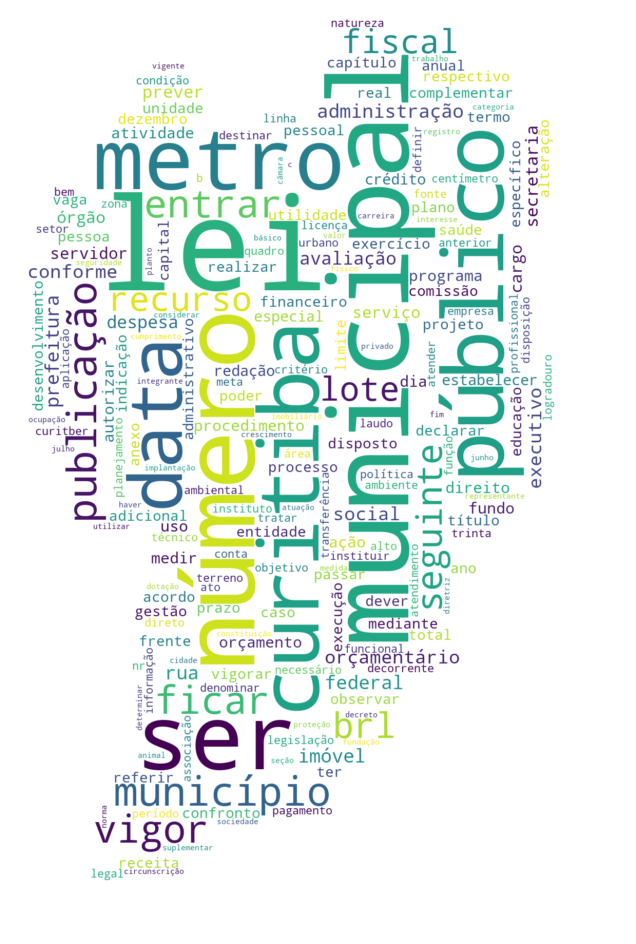

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    mask=plt.imread('assets/curitiba.jpg')).generate_from_frequencies(todas_palavras_sem_estrutura)

plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Nuvem de Palavras')
plt.show()

##### 1.4.4.4 *Bag of Words*

In [197]:
def bag_of_words(df, coluna_texto):
    # Transforma listas de strings em uma string única (juntando elementos com espaço)
    text_series = df[coluna_texto].fillna('').apply(lambda x: ' '.join(x))
    
    # Inicializando o CountVectorizer
    count_vectorizer = CountVectorizer()
    
    # Calculando a matriz do Bag of Words
    bow_matrix = count_vectorizer.fit_transform(text_series)
    
    # Criando um DataFrame com as contagens de palavras
    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())
    
    return bow_df

In [198]:
bag_of_words = bag_of_words(df, 'tokens_limpos')

In [199]:
bag_of_words

aa  aaa  aaaar  aab  aad  aadanscwbrmc  aapc  ab  abaixo  abamorr  ...  \
0      0    0      0    0    0             0     0   0       0        0  ...   
1      0    0      0    0    0             0     0   0       0        0  ...   
2      0    0      0    0    0             0     0   0       0        0  ...   
3      0    0      0    0    0             0     0   0       0        0  ...   
4      0    0      0    0    0             0     0   0       0        0  ...   
...   ..  ...    ...  ...  ...           ...   ...  ..     ...      ...  ...   
1453   0    0      0    0    0             0     0   0       0        0  ...   
1454   0    0      0    0    0             0     0   0       0        0  ...   
1455   0    0      0    0    0             0     0   0       0        0  ...   
1456   0    0      0    0    0             0     0   0       0        0  ...   
1457   0    0      0    0    0             0     0   0       0        0  ...   

      órgão  órgãoentidade  órgãosentidade  órtese  ônibus  ônus  última  \
0         0              0               0       0       0     0       0   
1         4              0               0       0       0     0       0   
2         0              0               0       0       0     1       0   
3         0              0               0       0       0     0       0   
4         1              0               0       0       0     0       0   
...     ...            ...             ...     ...     ...   ...     ...   
1453      0              0               0       0       0     0       0   
1454      4              0               0       0       0     0       0   
1455      0              0               0       0       0     0       0   
1456      0              0               0       0       0     0       0   
1457      1              0               0       0       0     1       0   

      último  útero  útil  
0          0      0     0  
1          0      0     0  
2          0      0     0  
3          0      0     0  
4          0      0     0  
...      ...    ...   ...  
1453       0      0     0  
1454       0      0     0  
1455       0      0     0  
1456       0      0     0  
1457       0      0     0  

[1458 rows x 10508 columns]

##### 1.4.4.5 TF-IDF (*Term Frequency and Inverse Document Frequency*)

In [200]:
# TF
def compute_tf(bow_df):
    # Normalizando a contagem para calcular o TF
    tf_df = bow_df.div(bow_df.sum(axis=1), axis=0)
    return tf_df

In [201]:
tf = compute_tf(bag_of_words)

In [202]:
print(tf)

       aa  aaa  aaaar  aab  aad  aadanscwbrmc  aapc   ab  abaixo  abamorr  \
0     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
2     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
3     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
4     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
...   ...  ...    ...  ...  ...           ...   ...  ...     ...      ...   
1453  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1454  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1455  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1456  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1457  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   

      ...     órgão  órgãoentidade  órgãosentidade  órtese  ônibus      ônu

In [203]:
# IDF
def calcular_idf(bow_df):
    # Número total de documentos
    N = bow_df.shape[0]

    # Contando o número de documentos em que cada palavra aparece (DF)
    df = (bow_df > 0).sum(axis=0)

    # Calculando o IDF usando a fórmula
    idf = np.log((N + 1) / (df + 1)) + 1  # +1 para evitar divisão por zero
    return idf

In [204]:
idf = calcular_idf(bag_of_words)

In [205]:
print(idf)

aa        6.676069
aaa       7.592359
aaaar     7.592359
aab       7.592359
aad       7.592359
            ...   
ônus      5.107453
última    6.899212
último    5.066631
útero     7.592359
útil      4.819771
Length: 10508, dtype: float64


In [206]:
# TF-IDF
def calcular_tfidf(tf_df, idf):
    # Multiplicando o TF pelo IDF para calcular o TF-IDF
    tfidf_df = tf_df * idf
    return tfidf_df

In [207]:
tfidf = calcular_tfidf(tf, idf)

In [208]:
tfidf

aa  aaa  aaaar  aab  aad  aadanscwbrmc  aapc   ab  abaixo  abamorr  \
0     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
2     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
3     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
4     0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
...   ...  ...    ...  ...  ...           ...   ...  ...     ...      ...   
1453  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1454  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1455  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1456  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   
1457  0.0  0.0    0.0  0.0  0.0           0.0   0.0  0.0     0.0      0.0   

      ...     órgão  órgãoentidade  órgãosentidade  órtese  ônibus      ônus  \
0     ...  0.000000            0.0             0.0     0.0     0.0  0.000000   
1     ...  0.014186            0.0             0.0     0.0     0.0  0.000000   
2     ...  0.000000            0.0             0.0     0.0     0.0  0.009803   
3     ...  0.000000            0.0             0.0     0.0     0.0  0.000000   
4     ...  0.049486            0.0             0.0     0.0     0.0  0.000000   
...   ...       ...            ...             ...     ...     ...       ...   
1453  ...  0.000000            0.0             0.0     0.0     0.0  0.000000   
1454  ...  0.149609            0.0             0.0     0.0     0.0  0.000000   
1455  ...  0.000000            0.0             0.0     0.0     0.0  0.000000   
1456  ...  0.000000            0.0             0.0     0.0     0.0  0.000000   
1457  ...  0.009631            0.0             0.0     0.0     0.0  0.015292   

      última  último  útero  útil  
0        0.0     0.0    0.0   0.0  
1        0.0     0.0    0.0   0.0  
2        0.0     0.0    0.0   0.0  
3        0.0     0.0    0.0   0.0  
4        0.0     0.0    0.0   0.0  
...      ...     ...    ...   ...  
1453     0.0     0.0    0.0   0.0  
1454     0.0     0.0    0.0   0.0  
1455     0.0     0.0    0.0   0.0  
1456     0.0     0.0    0.0   0.0  
1457     0.0     0.0    0.0   0.0  

[1458 rows x 10508 columns]

In [209]:
tfidf.iloc[99].sort_values(ascending=False).head(10)

inservível         0.261805
dispositivo        0.173359
serviço            0.157986
local              0.148801
sancionatória      0.130903
remover            0.123912
telecomunicação    0.123912
condutor           0.109303
permissionário     0.107001
elétrico           0.107001
Name: 99, dtype: float64

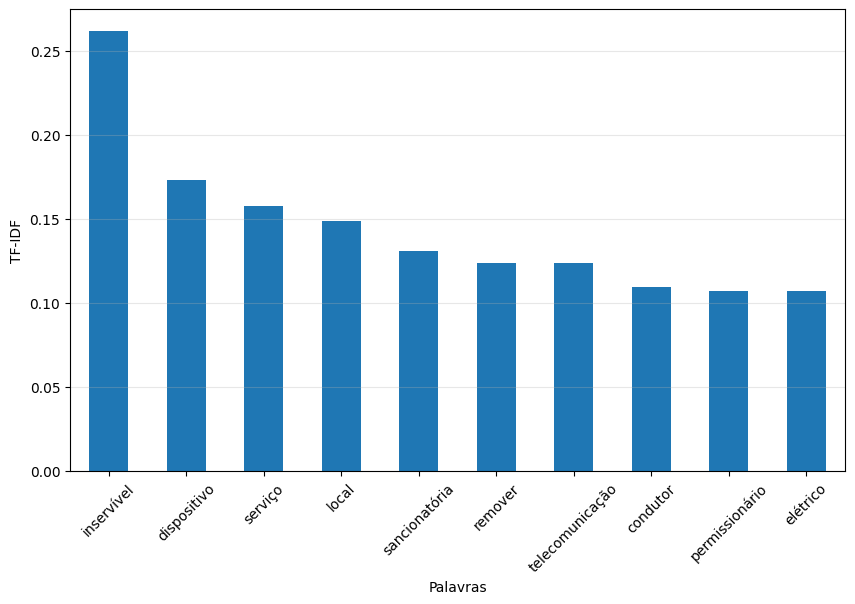

In [210]:
# Plotando as palavras mais importantes para o Documento 1
plt.figure(figsize=(10, 6))
tfidf.iloc[99].sort_values(ascending=False).head(10).plot(kind='bar')
#plt.title('Top 10 Palavras mais importantes no Documento 1')
plt.xlabel('Palavras')
plt.ylabel('TF-IDF')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.show()

##### 1.4.4.6 N-gramas

In [211]:
def gerar_ngramas(tokens, n=2):
    # Retornar os n-gramas como uma lista de tuplas
    return list(ngrams(tokens, n))

In [212]:
n = 4

In [213]:
df['ngramas'] = df['tokens_limpos'].apply(lambda x: gerar_ngramas(x, n))

all_ngramas = sum(df['ngramas'], [])
ngramas_freq = Counter(all_ngramas)

ngramas_freq_df = pd.DataFrame(ngramas_freq.items(), columns=['n-grama', 'frequência']).sort_values(by='frequência', ascending=False)

In [214]:
print(ngramas_freq_df.head(10))

                                         n-grama  frequência
125                   (lei, entrar, vigor, data)        1324
126            (entrar, vigor, data, publicação)        1320
1574        (passar, vigorar, seguinte, redação)         254
29          (lei, complementar, federal, número)         220
3461        (conforme, laudo, avaliação, número)         176
1785  (declarar, utilidade, público, associação)         175
1777     (logradouro, público, capital, nominar)         168
3460          (real, conforme, laudo, avaliação)         156
3468  (avaliação, imóvel, secretaria, municipal)         151
3467   (comissão, avaliação, imóvel, secretaria)         151


##### 1.4.4.7 *Part-of-Speech Tagging* e *Dependency Parsing*

In [215]:
def pos_tagging_e_dependency_parsing_completo(texto):
    doc = nlp(texto)

    # Tags POS para cada palavra
    pos_tags = [token.pos_ for token in doc]

    # Dependências sintáticas
    dependencies = [token.dep_ for token in doc]

    # Informações adicionais úteis
    tokens_info = [{
        'texto': token.text,
        'lema': token.lemma_,
        'pos': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'head': token.head.text,
        'is_stop': token.is_stop
    } for token in doc]

    return pos_tags, dependencies, tokens_info

In [216]:
def analisar_pos_tags(df, coluna='pos_tags'):
    # Flatten da lista de listas
    todas_pos_tags = [tag for tags_list in df[coluna] for tag in tags_list]

    # Contar frequências
    pos_counter = Counter(todas_pos_tags)

    return pos_counter

In [217]:
def analisar_dependencias(df, coluna='dependencias'):
    # Flatten da lista de listas
    todas_deps = [dep for deps_list in df[coluna] for dep in deps_list]

    # Contar frequências
    dep_counter = Counter(todas_deps)

    return dep_counter

In [218]:
def plotar_pos_tags(pos_counter, top_n=10, figsize=(12, 6)):
    # Pegar os top N mais comuns
    pos_mais_comuns = pos_counter.most_common(top_n)
    tags, counts = zip(*pos_mais_comuns)

    # Criar o gráfico
    plt.figure(figsize=figsize)
    plt.bar(tags, counts)
    plt.xlabel('Classes Gramaticais (POS Tags)', fontsize=12)
    plt.ylabel('Frequência', fontsize=12)
    #plt.title('Distribuição das Classes Gramaticais', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Imprimir legenda
    print("\nLegenda das POS Tags:")
    legendas = {
        'NOUN': 'Substantivo',
        'VERB': 'Verbo',
        'ADJ': 'Adjetivo',
        'ADV': 'Advérbio',
        'PRON': 'Pronome',
        'DET': 'Determinante',
        'ADP': 'Preposição',
        'CONJ': 'Conjunção',
        'NUM': 'Numeral',
        'PROPN': 'Nome Próprio',
        'PUNCT': 'Pontuação',
        'AUX': 'Verbo Auxiliar'
    }

    for tag, count in pos_mais_comuns:
        descricao = legendas.get(tag, 'Outro')
        print(f"  {tag}: {descricao} ({count} ocorrências)")

In [219]:
def plotar_dependencias(dep_counter, top_n=20, figsize=(14, 7)):
    # Pegar os top N mais comuns
    deps_mais_comuns = dep_counter.most_common(top_n)
    deps, counts = zip(*deps_mais_comuns)

    # Criar o gráfico
    plt.figure(figsize=figsize)
    plt.barh(deps, counts)
    plt.xlabel('Frequência', fontsize=12)
    plt.ylabel('Tipos de Dependência', fontsize=12)
    #plt.title('Distribuição dos Relacionamentos Sintáticos', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Imprimir informações
    print(f"\nTotal de tipos de dependências: {len(dep_counter)}")
    print(f"Top 10 dependências mais frequentes:")
    for dep, count in deps_mais_comuns[:10]:
        print(f"  {dep}: {count} ocorrências")

In [220]:
def plotar_pizza_pos_tags(pos_counter, top_n=8, figsize=(10, 8)):
    # Pegar os top N e agrupar o resto em "Outros"
    pos_mais_comuns = pos_counter.most_common(top_n)
    tags, counts = zip(*pos_mais_comuns)

    # Calcular "Outros"
    total_outros = sum(pos_counter.values()) - sum(counts)

    if total_outros > 0:
        tags = list(tags) + ['Outros']
        counts = list(counts) + [total_outros]

    # Criar o gráfico
    plt.figure(figsize=figsize)
    colors = plt.cm.Set3(range(len(tags)))
    plt.pie(counts, labels=tags, autopct='%1.1f%%', startangle=90,
            colors=colors, textprops={'fontsize': 11})
    #plt.title('Proporção das Classes Gramaticais', fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [221]:
def analise_por_sentenca(df, indice, coluna_sentencas='sentencas'):
    # Se a coluna contém listas de sentenças
    if isinstance(df[coluna_sentencas].iloc[indice], list):
        sentenca = df[coluna_sentencas].iloc[indice][7]  # primeira sentença
    else:
        sentenca = df[coluna_sentencas].iloc[indice]

    doc = nlp(sentenca)

    print(f"Sentença analisada: {sentenca}\n")

    # Contar POS tags
    pos_na_sentenca = Counter([token.pos_ for token in doc])
    print("Classes gramaticais nesta sentença:")
    for pos, count in pos_na_sentenca.most_common():
        print(f"  {pos}: {count}")

    print("\nDependências nesta sentença:")
    dep_na_sentenca = Counter([token.dep_ for token in doc])
    for dep, count in dep_na_sentenca.most_common():
        print(f"  {dep}: {count}")

    # Tabela detalhada
    print("\n" + "="*80)
    print(f"{'Token':<15} {'POS':<10} {'Dependência':<15} {'Head':<15}")
    print("="*80)
    for token in doc:
        print(f"{token.text:<15} {token.pos_:<10} {token.dep_:<15} {token.head.text:<15}")

    return doc

In [222]:
df['pos_tags'], df['dependencias'], df['tokens_info'] = zip(
    *df['lei_processada'].apply(pos_tagging_e_dependency_parsing_completo)
)

In [223]:
# Gerar análises
pos_counter = analisar_pos_tags(df)
dep_counter = analisar_dependencias(df)

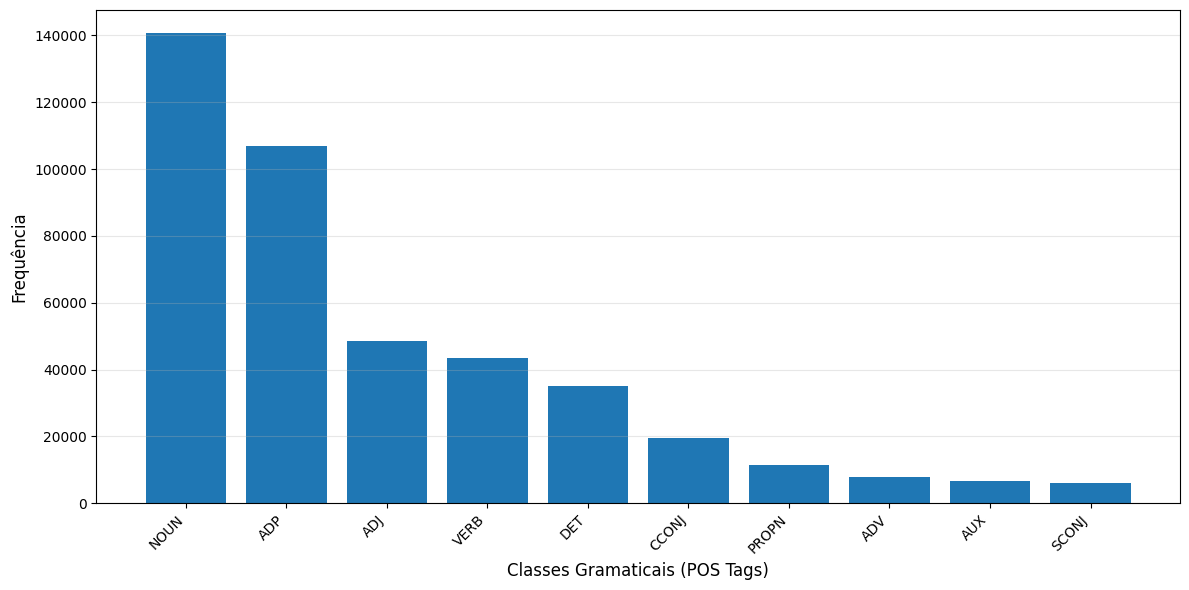


Legenda das POS Tags:
  NOUN: Substantivo (140585 ocorrências)
  ADP: Preposição (107006 ocorrências)
  ADJ: Adjetivo (48541 ocorrências)
  VERB: Verbo (43391 ocorrências)
  DET: Determinante (34970 ocorrências)
  CCONJ: Outro (19570 ocorrências)
  PROPN: Nome Próprio (11466 ocorrências)
  ADV: Advérbio (7815 ocorrências)
  AUX: Verbo Auxiliar (6492 ocorrências)
  SCONJ: Outro (6104 ocorrências)


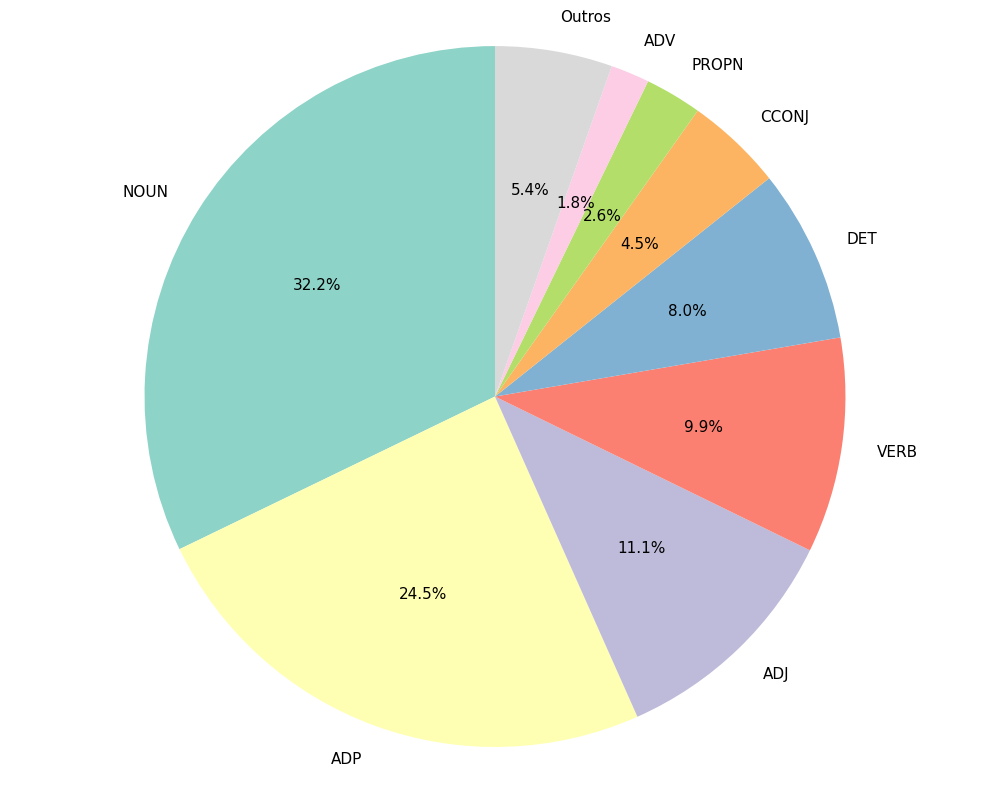

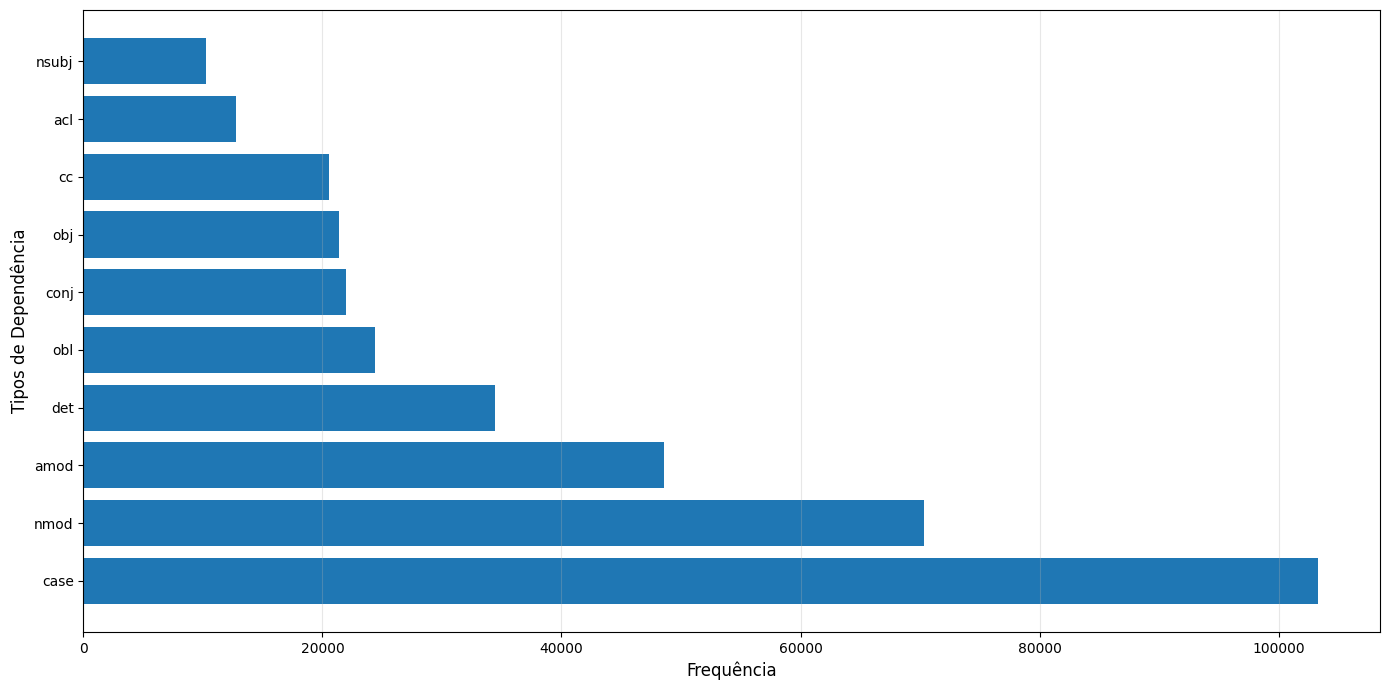


Total de tipos de dependências: 36
Top 10 dependências mais frequentes:
  case: 103320 ocorrências
  nmod: 70327 ocorrências
  amod: 48562 ocorrências
  det: 34453 ocorrências
  obl: 24408 ocorrências
  conj: 22008 ocorrências
  obj: 21347 ocorrências
  cc: 20572 ocorrências
  acl: 12774 ocorrências
  nsubj: 10273 ocorrências


In [224]:
# Criar visualizações
plotar_pos_tags(pos_counter, top_n=10)
plotar_pizza_pos_tags(pos_counter)
plotar_dependencias(dep_counter, top_n=10)

In [225]:
# Analisar sentença específica
doc = analise_por_sentenca(df, indice=7)
displacy.render(doc, style='dep', options={"distance": 100, "wordSpacing": 50, "offsetX": 20}, jupyter=True)

Sentença analisada: Esta lei entrará em vigor na data de sua publicação.

Classes gramaticais nesta sentença:
  NOUN: 4
  ADP: 3
  DET: 2
  VERB: 1
  PUNCT: 1

Dependências nesta sentença:
  case: 3
  det: 2
  obl: 2
  nsubj: 1
  ROOT: 1
  nmod: 1
  punct: 1

Token           POS        Dependência     Head           
Esta            DET        det             lei            
lei             NOUN       nsubj           entrará        
entrará         VERB       ROOT            entrará        
em              ADP        case            vigor          
vigor           NOUN       obl             entrará        
na              ADP        case            data           
data            NOUN       obl             entrará        
de              ADP        case            publicação     
sua             DET        det             publicação     
publicação      NOUN       nmod            data           
.               PUNCT      punct           entrará        


In [226]:
def pos_tagging_e_dependency_parsing(texto):
    doc = nlp(texto)
    # Retornar as tags POS para cada palavra
    pos_tags = [token.pos_ for token in doc]

    # Retornar a dependência sintática de cada palavra
    dependencies = [token.dep_ for token in doc]

    return pos_tags, dependencies

In [227]:
df['lei_processada'] = df['lei_processada'].astype(str)
df['lei_processada'] = df['lei_processada'].apply(lambda x: ''.join(char for char in x if char.isalpha() or char.isspace()))

In [228]:
def normalizar_texto(texto):
    if not isinstance(texto, str):
        return ''
    
    tokens = word_tokenize(texto)
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatisados = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens_lemmatisados)

In [229]:
df['lei_normalizada'] = normalizar_texto(df['lei_processada'])

In [230]:
df['pos_tags'], df['dependencias'] = zip(*df['lei_normalizada'].apply(pos_tagging_e_dependency_parsing))

In [231]:
pd.set_option('display.max_colwidth', 1000)
df[['numeracao', 'ano', 'sentencas','pos_tags','dependencias']]

numeracao   ano  \
0       15797.0  2020   
1       15798.0  2020   
2       15779.0  2020   
3       15778.0  2020   
4       15780.0  2020   
...         ...   ...   
1453    15021.0  2017   
1454        NaN  2017   
1455    14966.0  2017   
1456    14990.0  2017   
1457    14992.0  2017   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sentencas  \
0     [Art. 1º Ficam incluídas, alteradas e excluídas no Anexo I - Das Metas e Prioridades da Administração Municipal, aprovado na Lei Municipal nº 15.669, de 3 de julho de 2020 - Lei de Diretrizes Orçamentárias para 2021, as ações discriminadas na forma do Anexo I, desta lei., Art. 2º Ficam atualizados os valores dos quadros do Anexo de Metas Fiscais, determinados pelo § 1º, e pelo inciso II, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constantes na Lei Municipal nº 15.669, de 2020., Art. 3º Fica alterado o Anexo de Avaliação Atuarial e Financeira do Sistema Previdenciário do Município, determinado pelo inciso IV, do § 2º, do art. 4º, da Lei Complementar Federal nº 101, de 4 de maio de 2000, constante na Lei Municipal nº 15.669, de 2020., Art. 4º Fica o Poder Executivo autorizado a repassar recursos a título de garantia, honra de avais, seguros e similares, autorizados por lei específica, incluídos na Lei Orçamentária Anual ou em seus créditos adiciona...   
1     [TÍTULO, I, DAS DISPOSIÇÕES, PRELIMINARES, Art. 1º, Esta lei estima a Receita e fixa a Despesa do Município de Curitiba para o exercício financeiro de 2021, compreendendo: I - Orçamento Fiscal, referente aos Poderes do Município, incluídos os órgãos e entidades da Administração Pública Municipal; II - Orçamento da Seguridade Social, composto pelas entidades e órgãos vinculados à saúde, à assistência social e à previdência; III - Orçamento de Investimento, o qual abrange as empresas em que o Município, direta ou indiretamente, detém a maioria do capital social com direito a voto., TÍTULO II, DOS ORÇAMENTOS, FISCAL, E DA SEGURIDADE SOCIAL CAPÍTULO I DA ESTIMATIVA DA RECEITA, Art. 2º, A Receita Total dos Orçamentos Fiscal e da Seguridade Social é de R$ 8.127.000.000,00, decorrentes da arrecadação de tributos próprios e transferidos, contribuições e demais receitas correntes e de capital, na forma da legislação vigente e de acordo com cada orçamento: I - A Receita do Orçamento Fiscal é...   
2     [Art. 1º Fica o Poder Executivo Municipal autorizado a constituir uma sociedade por ações, de propósito específico, de capital fechado, dotada de personalidade jurídica de direito privado, na forma da Lei Federal nº 6.404, de 15 de dezembro de 1976 e suas alterações, e da Lei Federal nº 13.303, de 30 de junho de 2016, com a Companhia Paranaense de Energia – COPEL, ou subsidiária integral dessa, nos termos da Lei Estadual nº 1.384, de 11 de novembro de 1953, com as alterações da Lei Estadual nº 16.652, de 2010, sob a denominação Usina Fotovoltaica e de Biomassa Caximba S/A, para geração distribuída, conforme regulamentação da Agência Nacional de Energia Elétrica – 

In [294]:
X = tfidf.values

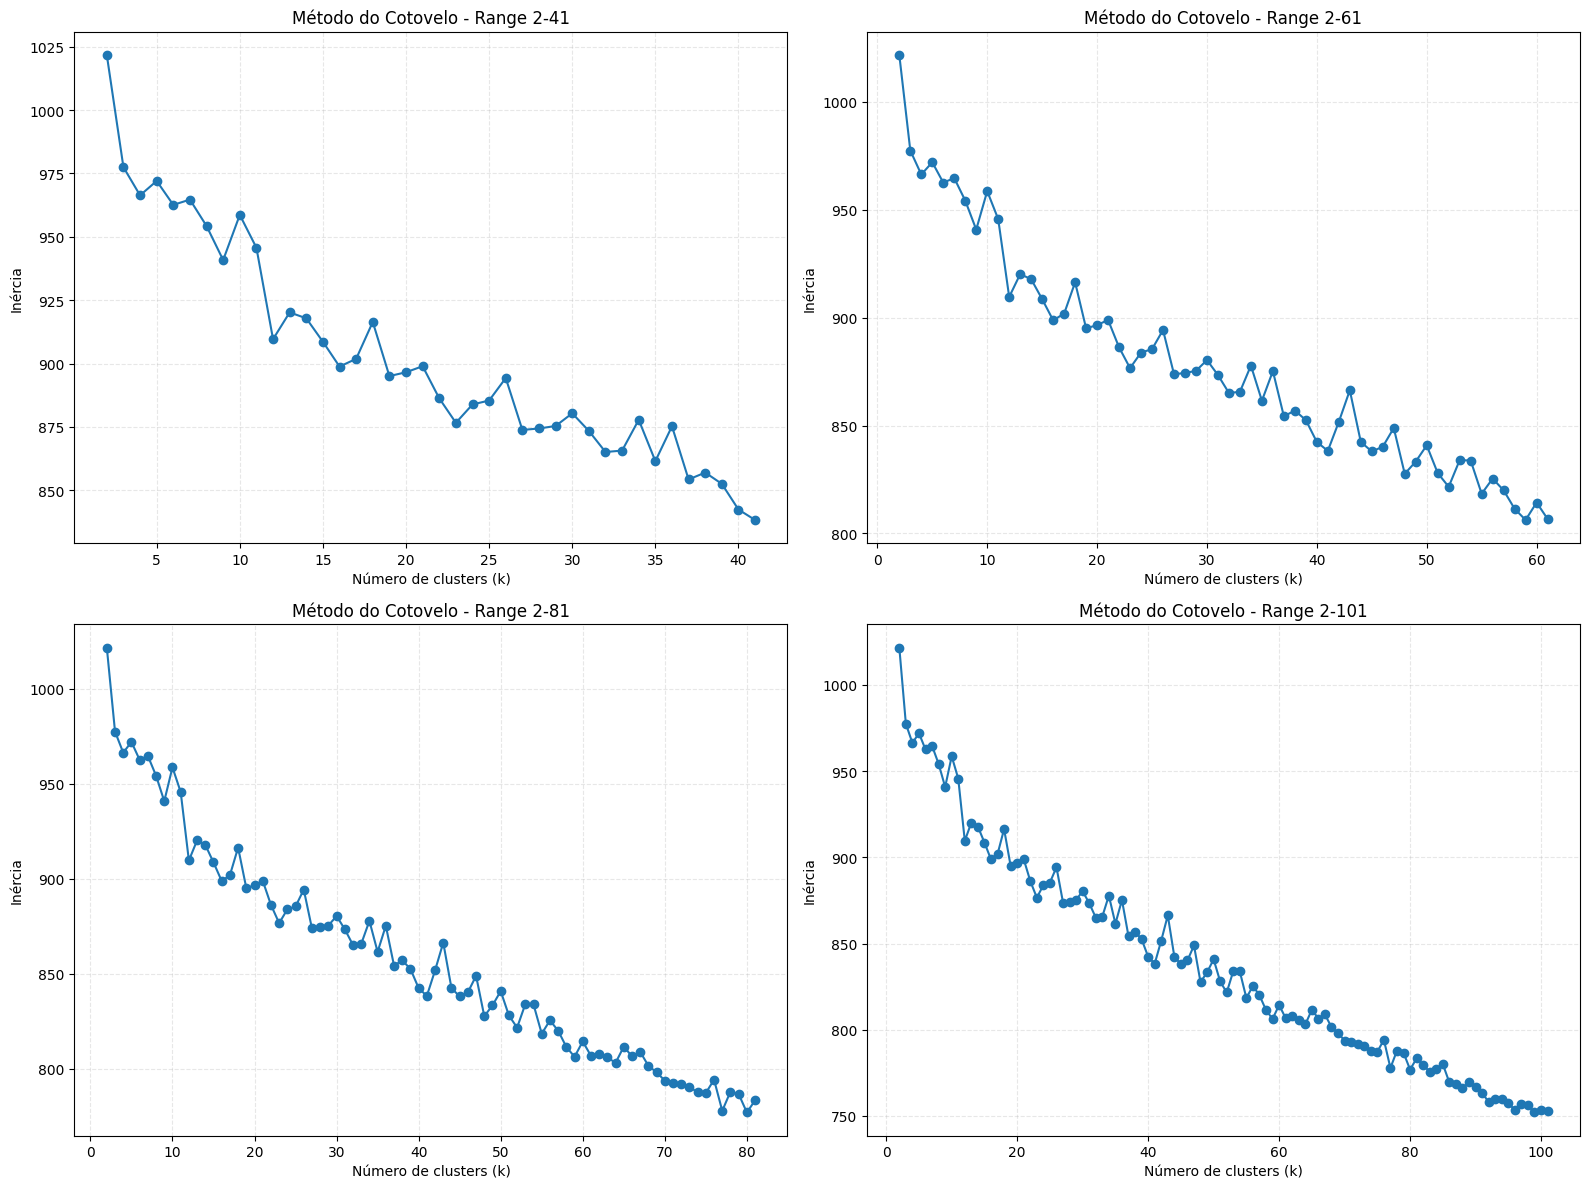

In [295]:
ranges = [
    (2, 41),
    (2, 61),
    (2, 81),
    (2, 101)
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()  # Transforma a estrutura 2D em 1D para facilitar o loop

for i, (start, end) in enumerate(ranges):
    k_values = range(start, end + 1)
    inertia = []
    
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X)
        inertia.append(km.inertia_)
    
    # Plot no subplot correspondente
    axes[i].plot(k_values, inertia, marker='o')
    axes[i].set_xlabel("Número de clusters (k)")
    axes[i].set_ylabel("Inércia")
    axes[i].set_title(f"Método do Cotovelo - Range {start}-{end}")
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
#plt.suptitle("Método do Cotovelo para Diferentes Ranges", fontsize=16)
plt.show()


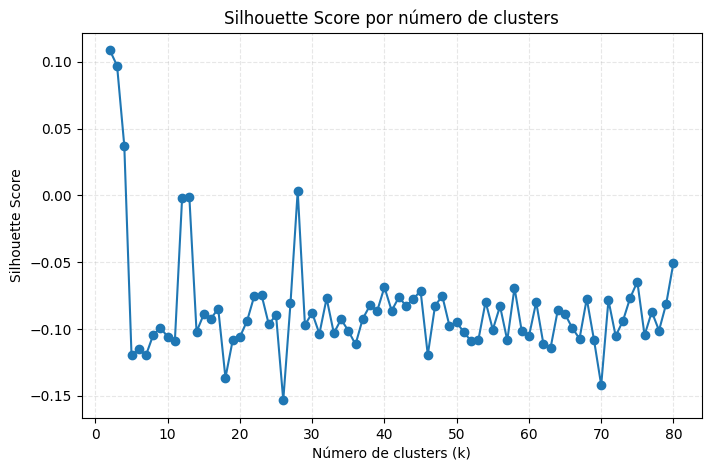

In [296]:
silhouette_scores = []

for k in range(2, 81):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 81), silhouette_scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score por número de clusters")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


In [297]:
resultados = []

for k in range(25, 36):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)

    # Tamanho dos clusters
    _, counts = np.unique(labels, return_counts=True)

    resultados.append({
        "k": k,
        "menor_cluster": counts.min(),
        "maior_cluster": counts.max(),
        "media_cluster": counts.mean(),
        "mediana_cluster": np.median(counts)
    })

df_clusters = pd.DataFrame(resultados)
print(df_clusters)

     k  menor_cluster  maior_cluster  media_cluster  mediana_cluster
0   25              1            486      58.320000              3.0
1   26              1            662      56.076923              1.5
2   27              1            612      54.000000              2.0
3   28              1            529      52.071429              3.0
4   29              1            608      50.275862              4.0
5   30              1            637      48.600000              1.0
6   31              1            512      47.032258              4.0
7   32              1            587      45.562500              1.0
8   33              1            523      44.181818              5.0
9   34              1            563      42.882353              1.0
10  35              1            479      41.657143              3.0


## 2 Redução de dimensionalidade

In [298]:
modelo = Word2Vec(
    sentences=df['tokens_limpos'],
    vector_size=64,
    window=5,
    min_count=2,
    workers=16,
    sg=1,
    epochs=10,
    seed=42
)

vetor_palavras = modelo.wv

In [299]:
todas_palavras = [palavra for tokens in df['tokens_limpos'] for palavra in tokens]
freq_palavras = Counter(todas_palavras)
palavras_top = [palavra for palavra, _ in freq_palavras.most_common(5000)]

# Filtrar apenas palavras que existem no vocabulário
palavras = [p for p in palavras_top if p in vetor_palavras]
vetores = np.array([vetor_palavras[p] for p in palavras])

In [300]:
pca_full = PCA()
pca_full.fit(vetores)

variancia_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

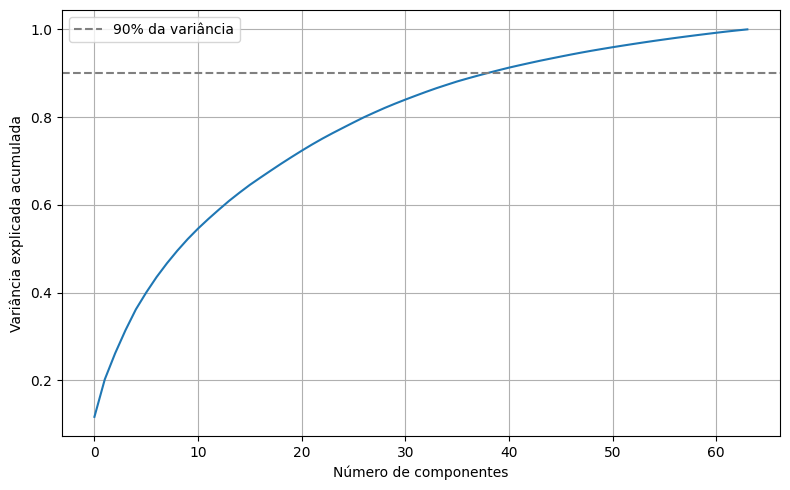

In [301]:
plt.figure(figsize=(8, 5))
plt.plot(variancia_acumulada)
plt.axhline(0.9, linestyle="--", color="gray", label="90% da variância")
plt.xlabel("Número de componentes")
plt.ylabel("Variância explicada acumulada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [302]:
limiar = 0.90

n_componentes_90 = np.argmax(variancia_acumulada >= limiar) + 1

print(f"Número exato de componentes para atingir 90% da variância: {n_componentes_90}")
print(f"Variância explicada nesse ponto: {variancia_acumulada[n_componentes_90 - 1]:.2%}")

Número exato de componentes para atingir 90% da variância: 39
Variância explicada nesse ponto: 90.08%


### 2.1 Resultados salvos (reprodutibilidade)

- Rodar apenas as células abaixo e os respectivos gráficos

In [303]:
# Carregando resultados salvos
#resultado_umap = np.load("results/umap_2d.npy")
#labels_hdbscan = np.load("results/labels_hdbscan.npy")
#labels_kmeans = np.load("results/labels_kmeans.npy")

### 2.2 PCA

In [304]:
# PCA
pca = PCA(n_components=2, random_state=42)
resultado_pca = pca.fit_transform(vetores)

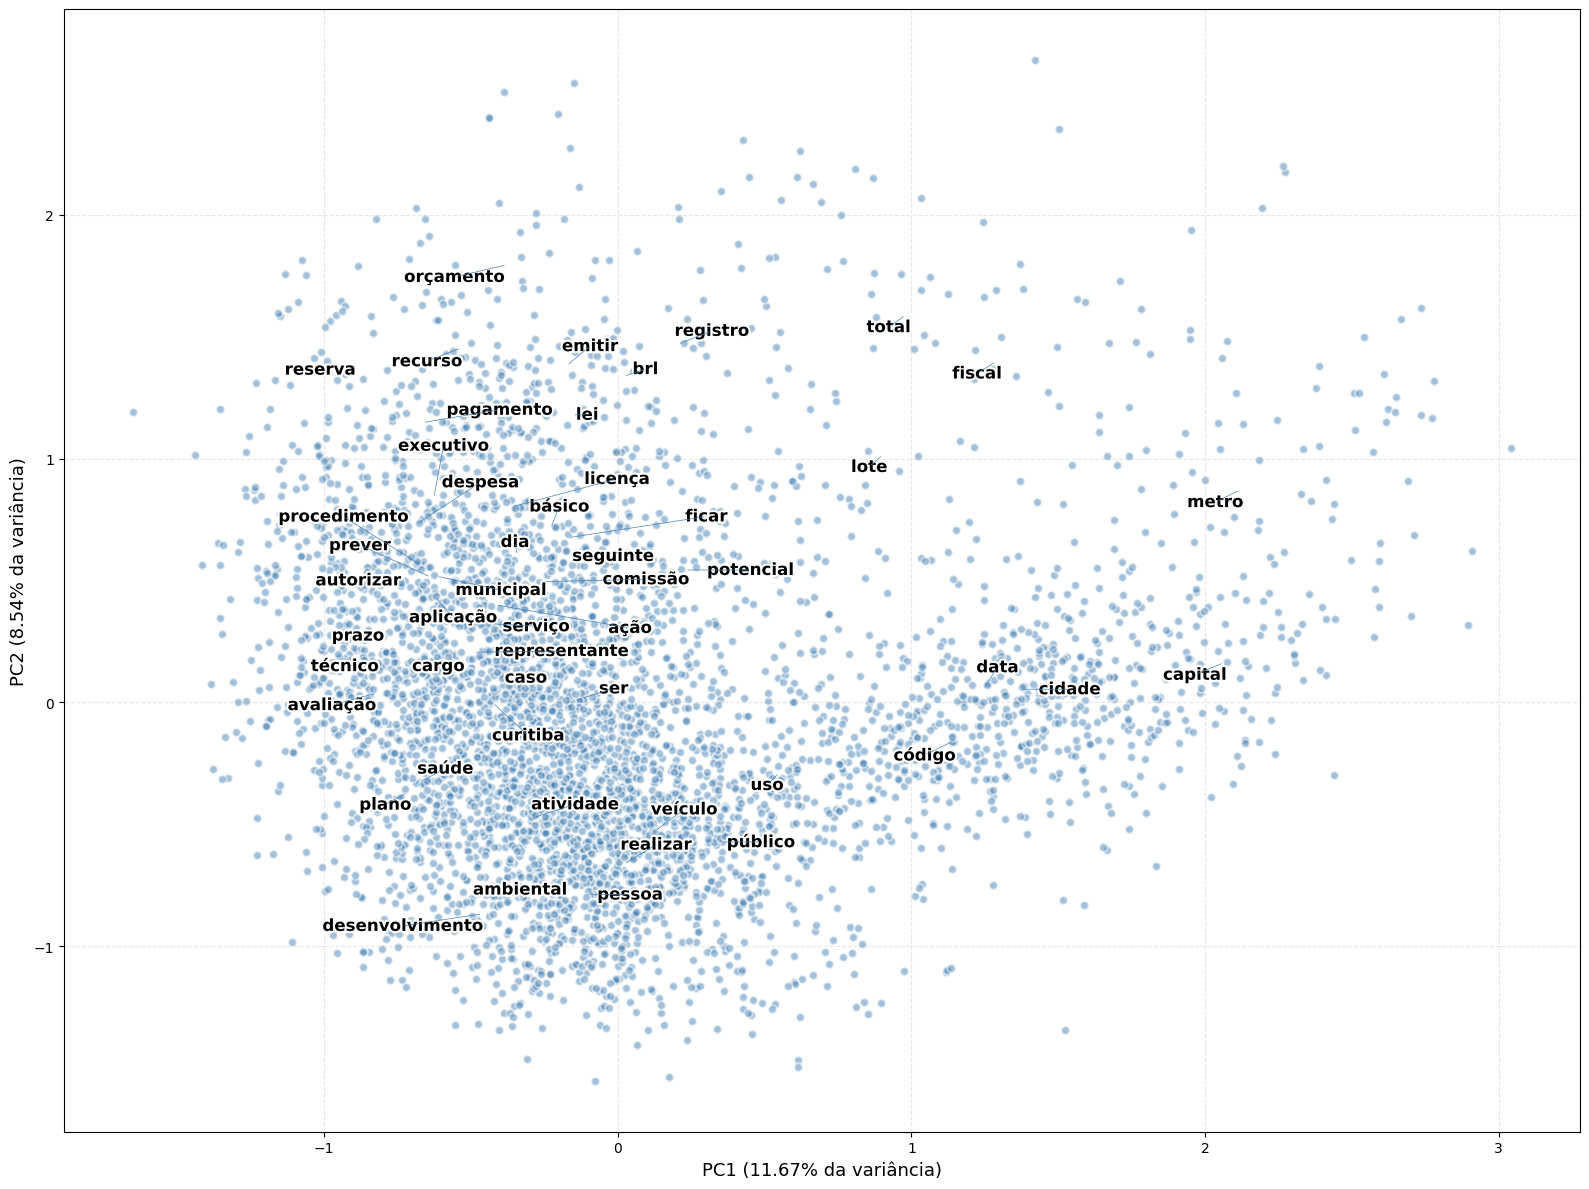

PCA - Variância explicada: 20.21%
  PC1: 11.67%
  PC2: 8.54%



In [305]:
plt.figure(figsize=(16, 12))

k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(vetores)

plt.scatter(
    resultado_pca[:, 0],
    resultado_pca[:, 1],
    c='steelblue',
    alpha=0.5,
    edgecolors='white',
    linewidth=1.5
)

texts = []

for i in range(k):
    idx = np.where(labels == i)[0]
    centro_cluster = resultado_pca[idx].mean(axis=0)
    palavra_rep = palavras[idx[0]]

    txt = plt.text(
        centro_cluster[0],
        centro_cluster[1],
        palavra_rep,
        fontsize=12,
        fontweight='bold',
        color="black",
        ha="center",
        va="center",
        path_effects=[
            pe.Stroke(linewidth=3, foreground="white"),
            pe.Normal()
        ]
    )
    texts.append(txt)

adjust_text(
    texts,
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_text=(0.5, 0.5),
    arrowprops=dict(arrowstyle="-", color="steelblue", lw=0.5)
)

variancia_total = sum(pca.explained_variance_ratio_)
# plt.title(f'PCA - Principal Component Analysis\nVariância Explicada: {variancia_total:.2%}',
#         fontsize=16, fontweight='bold', pad=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} da variância)', fontsize=13)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} da variância)', fontsize=13)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"PCA - Variância explicada: {variancia_total:.2%}")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}\n")


### 2.3 t-SNE

In [306]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,
    learning_rate=200,
    init='pca',
    random_state=42
)

resultado_tsne = tsne.fit_transform(vetores)

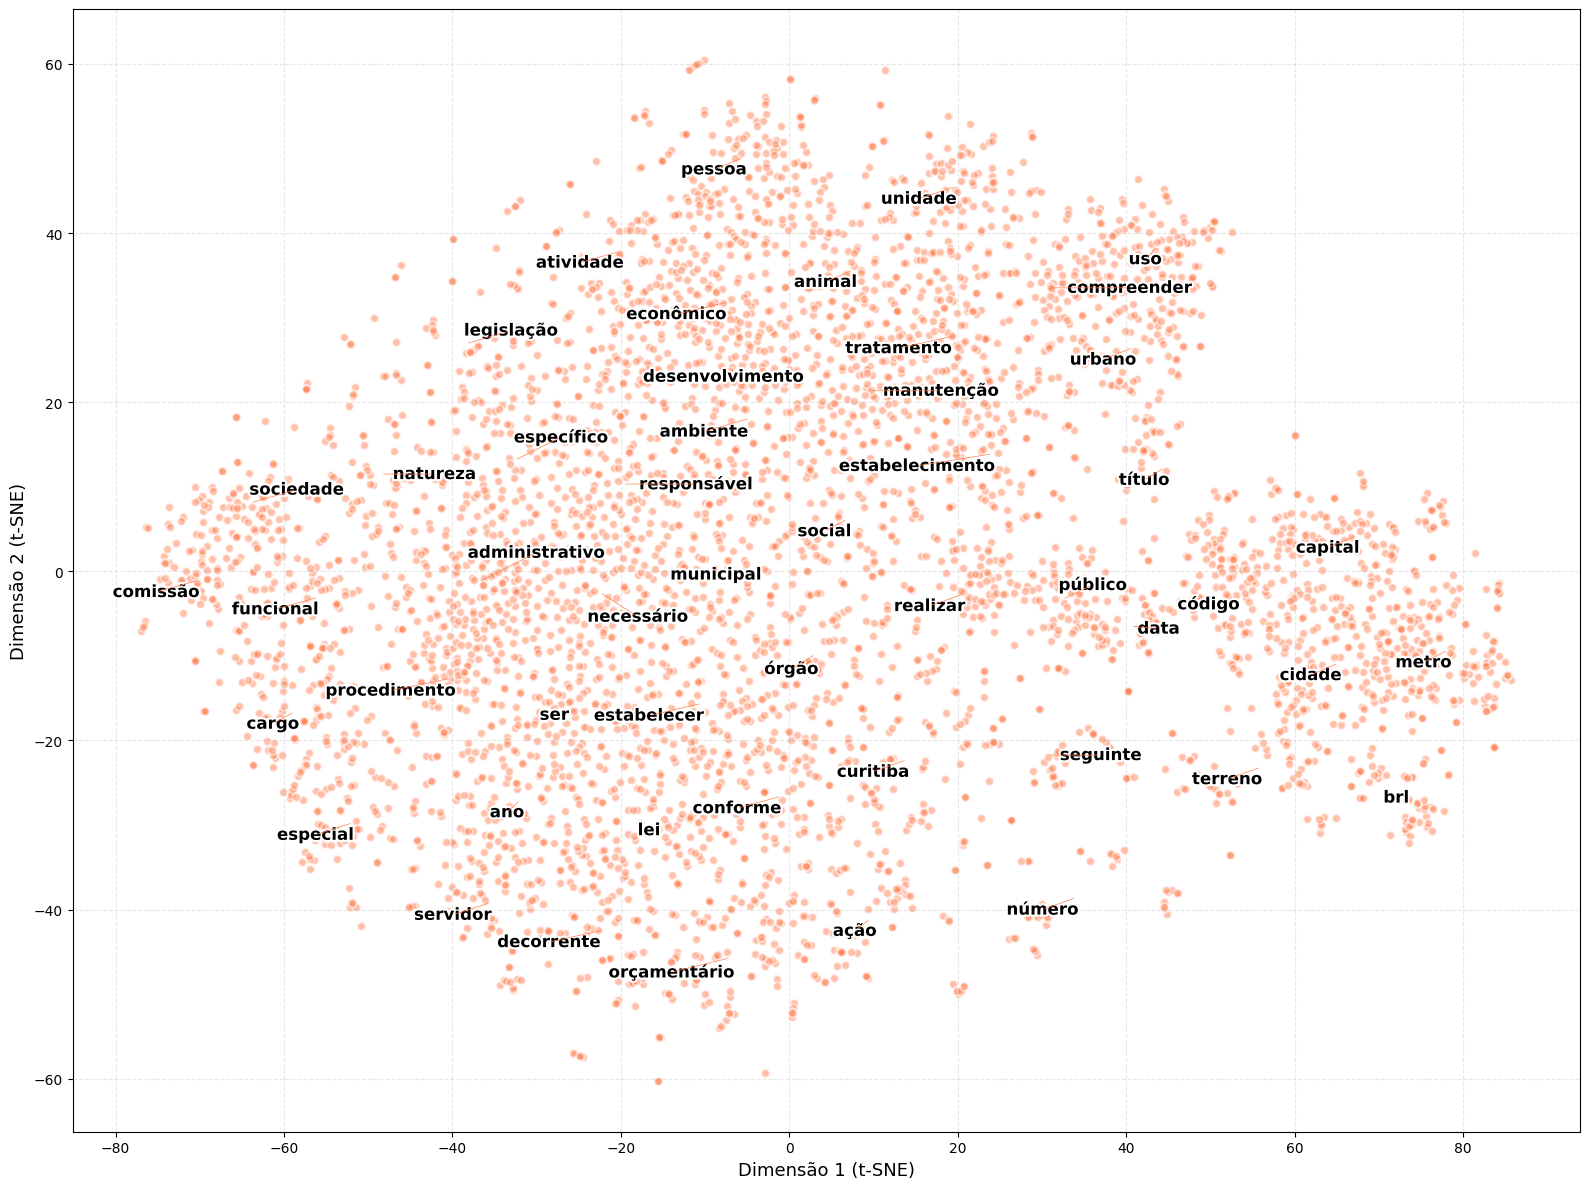

In [307]:
# t-SNE
plt.figure(figsize=(16, 12))

# K-Means NO ESPAÇO t-SNE
k = 50  # mesmo k usado no UMAP
kmeans_tsne = KMeans(n_clusters=k, random_state=42)
labels_tsne = kmeans_tsne.fit_predict(resultado_tsne)

# Scatter
plt.scatter(
    resultado_tsne[:, 0],
    resultado_tsne[:, 1],
    c='coral',
    alpha=0.5,
    edgecolors='white',
    linewidth=1.5
)

texts = []

for i in range(k):
    idx = np.where(labels_tsne == i)[0]
    if len(idx) == 0:
        continue

    centro_cluster = resultado_tsne[idx].mean(axis=0)
    palavra_rep = palavras[idx[0]]

    txt = plt.text(
        centro_cluster[0],
        centro_cluster[1],
        palavra_rep,
        fontsize=12,
        fontweight='bold',
        color="black",
        ha="center",
        va="center",
        path_effects=[
            pe.Stroke(linewidth=3, foreground="white"),
            pe.Normal()
        ]
    )
    texts.append(txt)

adjust_text(
    texts,
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_text=(0.5, 0.5),
    arrowprops=dict(arrowstyle="-", color="coral", lw=0.5)
)

plt.xlabel('Dimensão 1 (t-SNE)', fontsize=13)
plt.ylabel('Dimensão 2 (t-SNE)', fontsize=13)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### 2.4 UMAP

In [308]:
# UMAP
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.3,
    metric='cosine',
    random_state=42
)

resultado_umap = reducer.fit_transform(vetores)

c:\Users\Luis Henrique Paiva\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


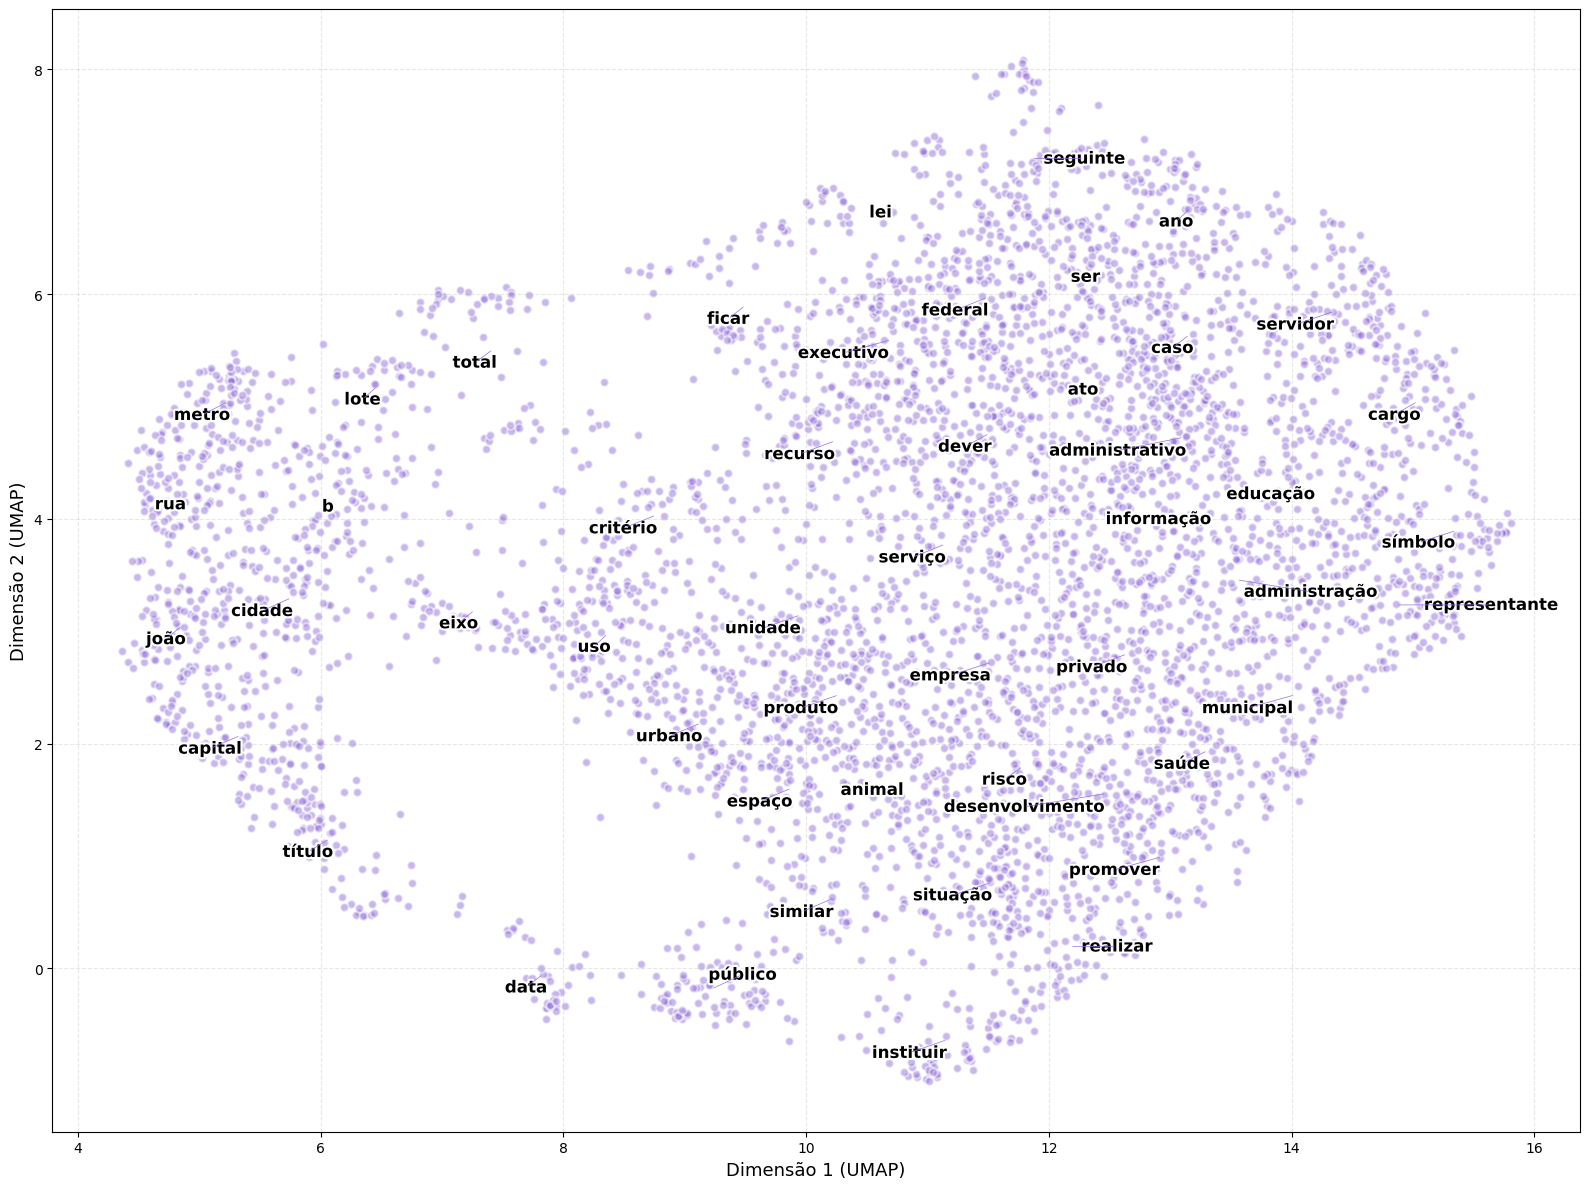

In [309]:
plt.figure(figsize=(16, 12))

# K-Means NO ESPAÇO UMAP
k = 50
kmeans_umap = KMeans(n_clusters=k, random_state=42)
labels_umap = kmeans_umap.fit_predict(resultado_umap)

# Scatter
plt.scatter(
    resultado_umap[:, 0],
    resultado_umap[:, 1],
    c='mediumpurple',
    alpha=0.5,
    edgecolors='white',
    linewidth=1.5
)

texts = []

for i in range(k):
    idx = np.where(labels_umap == i)[0]
    if len(idx) == 0:
        continue

    centro_cluster = resultado_umap[idx].mean(axis=0)
    palavra_rep = palavras[idx[0]]

    txt = plt.text(
        centro_cluster[0],
        centro_cluster[1],
        palavra_rep,
        fontsize=12,
        fontweight='bold',
        color="black",
        ha="center",
        va="center",
        path_effects=[
            pe.Stroke(linewidth=3, foreground="white"),
            pe.Normal()
        ]
    )
    texts.append(txt)

adjust_text(
    texts,
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_text=(0.5, 0.5),
    arrowprops=dict(arrowstyle="-", color="mediumpurple", lw=0.5)
)

plt.xlabel('Dimensão 1 (UMAP)', fontsize=13)
plt.ylabel('Dimensão 2 (UMAP)', fontsize=13)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### 2.5 Comparação PCA x t-SNE x UMAP

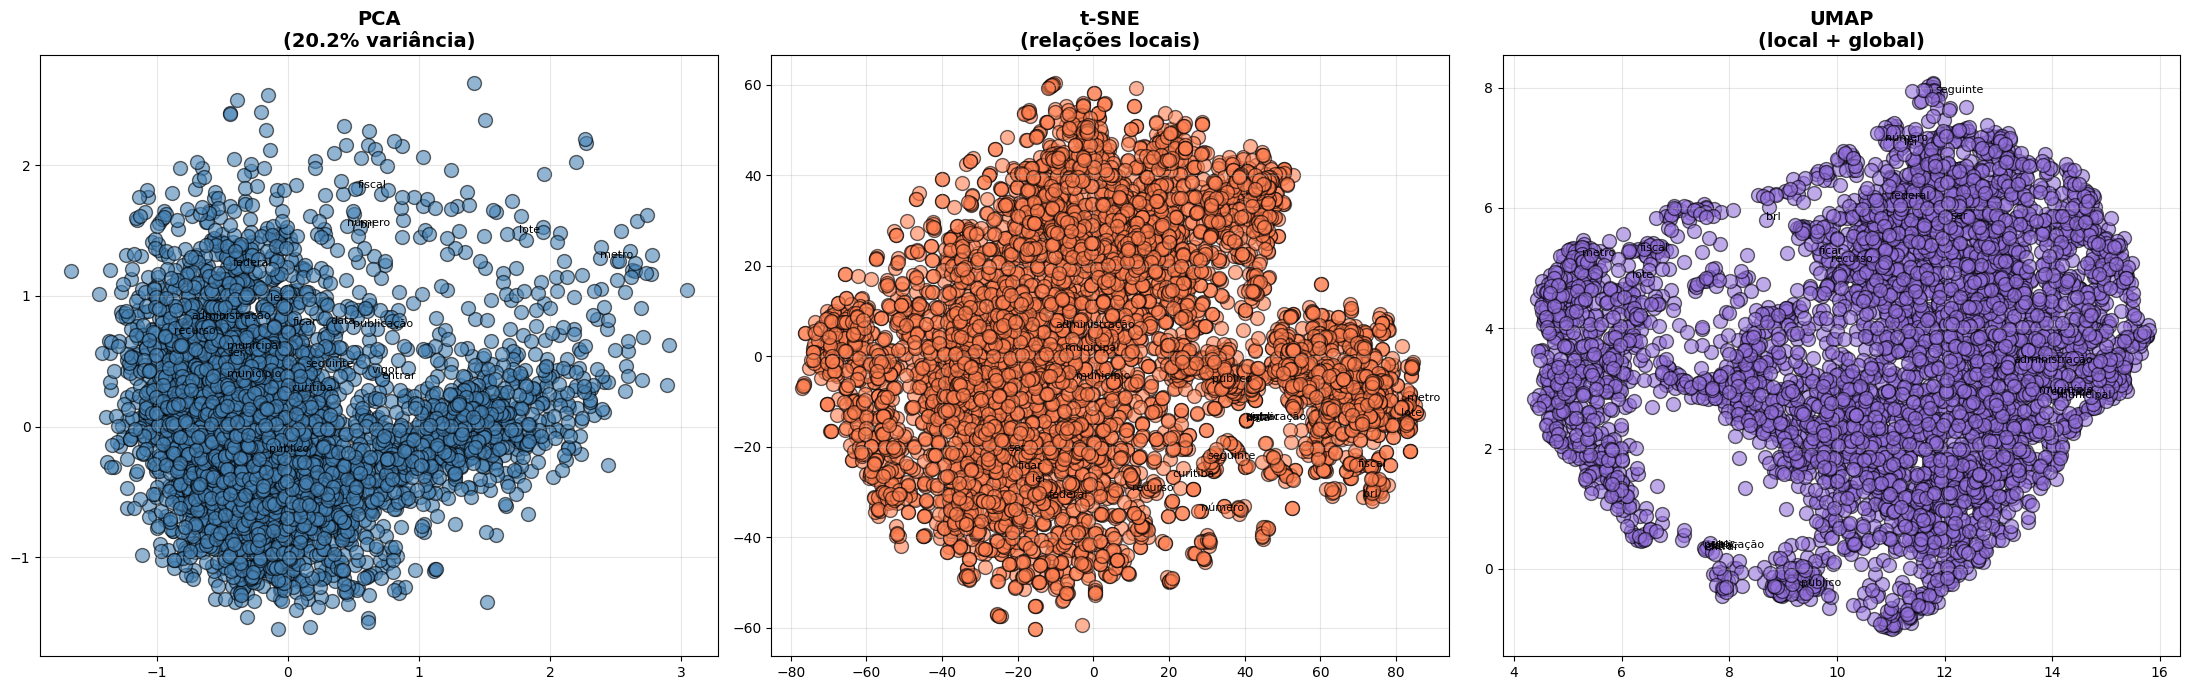

In [310]:
# COMPARAÇÃO LADO A LADO
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# PCA
axes[0].scatter(resultado_pca[:, 0], resultado_pca[:, 1],
               alpha=0.6, s=100, c='steelblue', edgecolors='black')
for i, palavra in enumerate(palavras[:20]):  # Apenas 20 para não poluir
    axes[0].annotate(palavra, xy=(resultado_pca[i, 0], resultado_pca[i, 1]),
                    fontsize=8)
axes[0].set_title(f'PCA\n({variancia_total:.1%} variância)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# t-SNE
axes[1].scatter(resultado_tsne[:, 0], resultado_tsne[:, 1],
               alpha=0.6, s=100, c='coral', edgecolors='black')
for i, palavra in enumerate(palavras[:20]):
    axes[1].annotate(palavra, xy=(resultado_tsne[i, 0], resultado_tsne[i, 1]),
                    fontsize=8)
axes[1].set_title('t-SNE\n(relações locais)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# UMAP
axes[2].scatter(resultado_umap[:, 0], resultado_umap[:, 1],
               alpha=0.6, s=100, c='mediumpurple', edgecolors='black')
for i, palavra in enumerate(palavras[:20]):
    axes[2].annotate(palavra, xy=(resultado_umap[i, 0], resultado_umap[i, 1]),
                    fontsize=8)
axes[2].set_title('UMAP\n(local + global)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

#plt.suptitle('Comparação dos Métodos de Redução Dimensional',
#            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3 Algoritmos de agrupamento (clustering)

### 3.1 K-Means

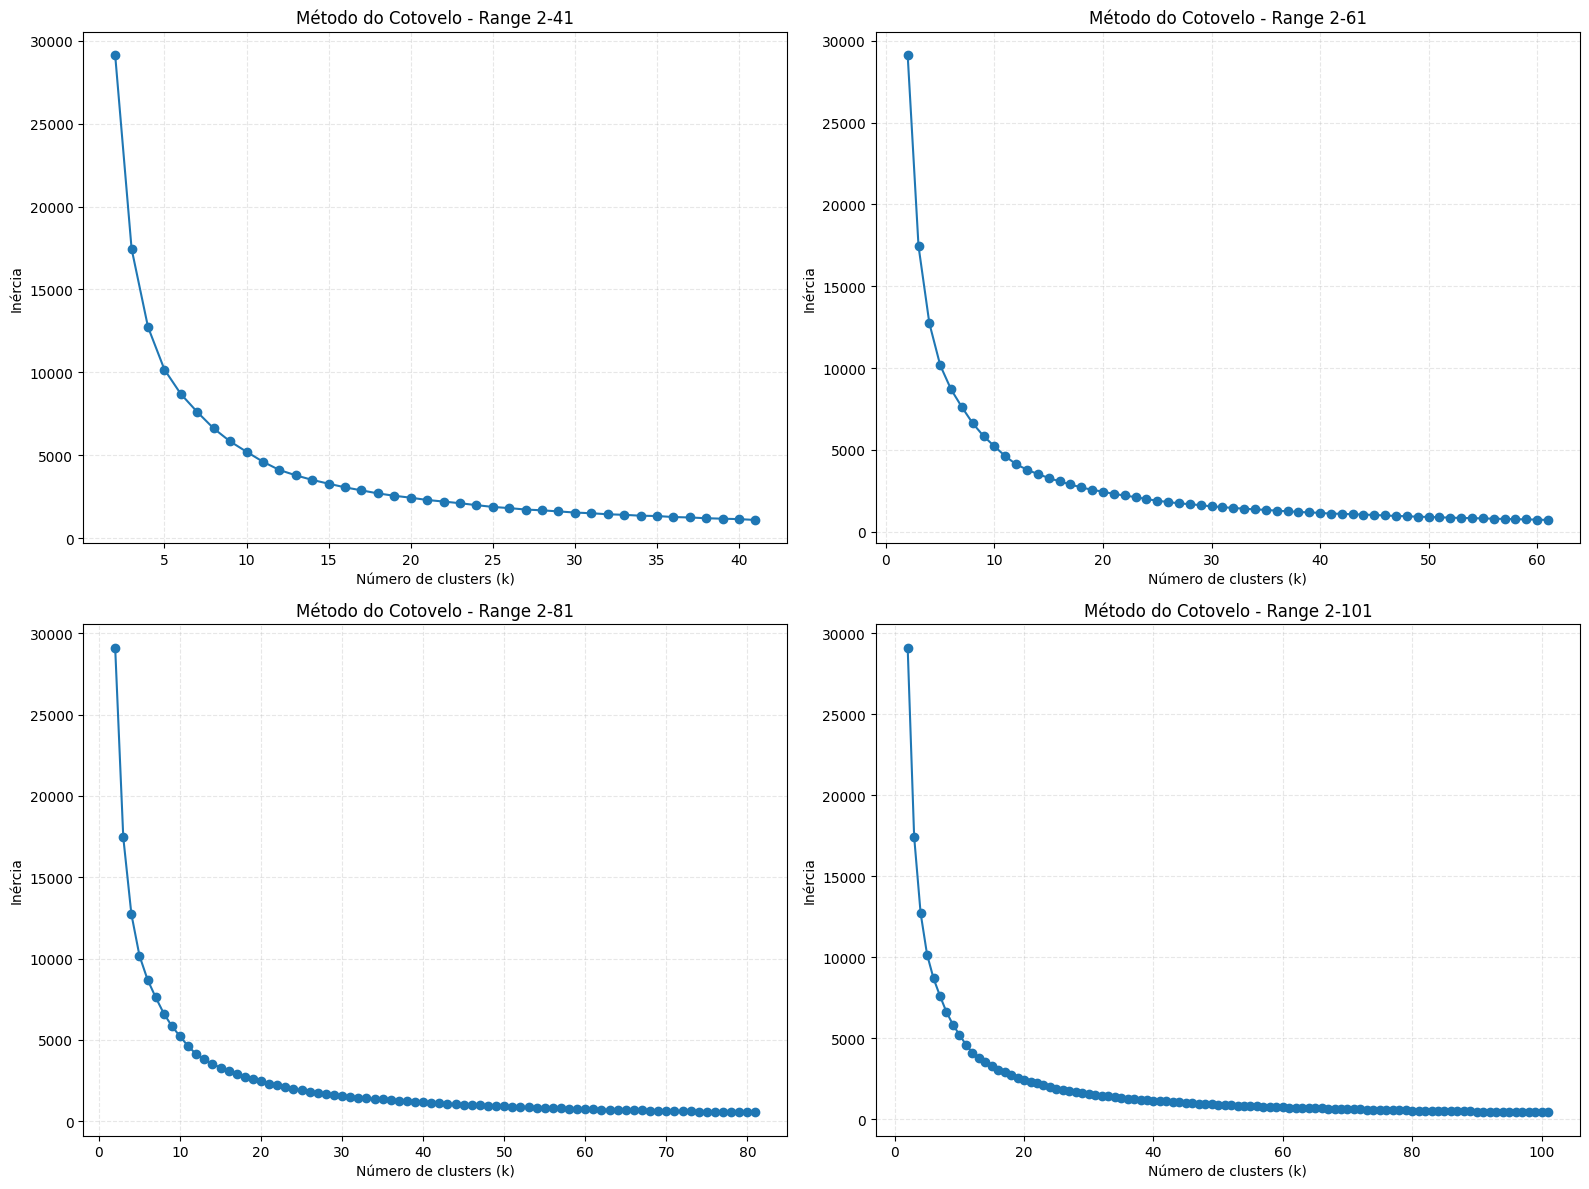

In [311]:
ranges = [
    (2, 41),
    (2, 61),
    (2, 81),
    (2, 101)
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()  # Transforma a estrutura 2D em 1D para facilitar o loop

for i, (start, end) in enumerate(ranges):
    k_values = range(start, end + 1)
    inertia = []
    
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(resultado_umap)
        inertia.append(km.inertia_)
    
    # Plot no subplot correspondente
    axes[i].plot(k_values, inertia, marker='o')
    axes[i].set_xlabel("Número de clusters (k)")
    axes[i].set_ylabel("Inércia")
    axes[i].set_title(f"Método do Cotovelo - Range {start}-{end}")
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
#plt.suptitle("Método do Cotovelo para Diferentes Ranges", fontsize=16)
plt.show()


99 99


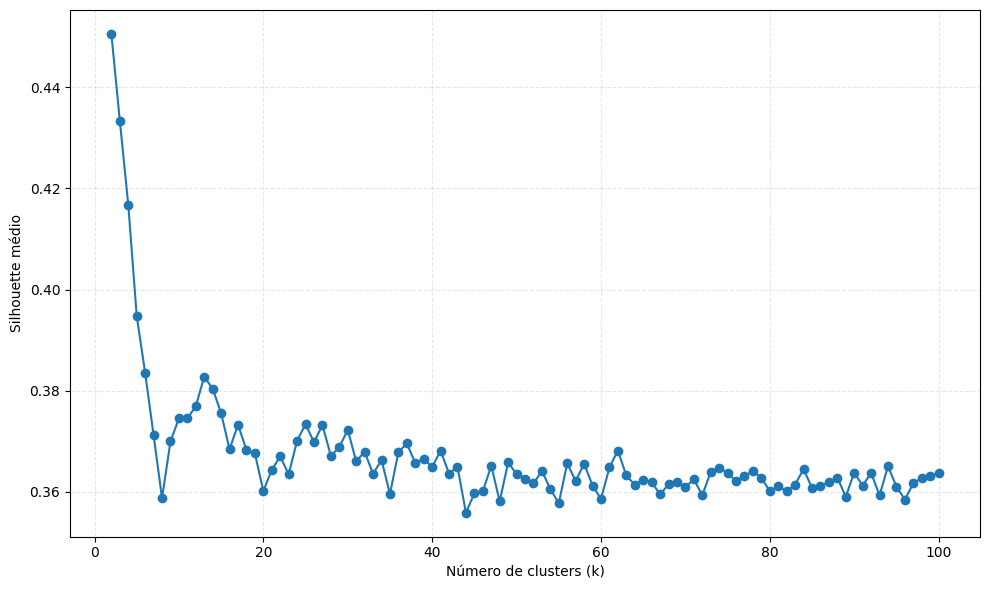

In [312]:
from sklearn.metrics import silhouette_score

k_values = list(range(2, 101))
silhouette_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(resultado_umap)
    score = silhouette_score(resultado_umap, labels, metric='euclidean')
    silhouette_scores.append(score)

print(len(k_values), len(silhouette_scores))

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette médio")
#plt.title("Silhouette Score no Espaço Reduzido por UMAP")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [313]:
resultados = []

for k in range(10, 101):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)

    # Tamanho dos clusters
    _, counts = np.unique(labels, return_counts=True)

    resultados.append({
        "k": k,
        "menor_cluster": counts.min(),
        "maior_cluster": counts.max(),
        "media_cluster": counts.mean(),
        "mediana_cluster": np.median(counts)
    })

df_clusters = pd.DataFrame(resultados)
print(df_clusters)

      k  menor_cluster  maior_cluster  media_cluster  mediana_cluster
0    10              1            683     145.800000              5.0
1    11              1            523     132.545455             65.0
2    12              1            721     121.500000             41.0
3    13              1            700     112.153846             16.0
4    14              1            784     104.142857             22.5
..  ...            ...            ...            ...              ...
86   96              1            495      15.187500              1.0
87   97              1            470      15.030928              1.0
88   98              1            470      14.877551              1.0
89   99              1            422      14.727273              1.0
90  100              1            300      14.580000              1.0

[91 rows x 5 columns]


In [314]:
# K-Means final no espaço reduzido pelo UMAP
k_final = 58

kmeans_umap = KMeans(n_clusters=k_final, random_state=42, n_init=10)
labels_umap = kmeans_umap.fit_predict(resultado_umap)

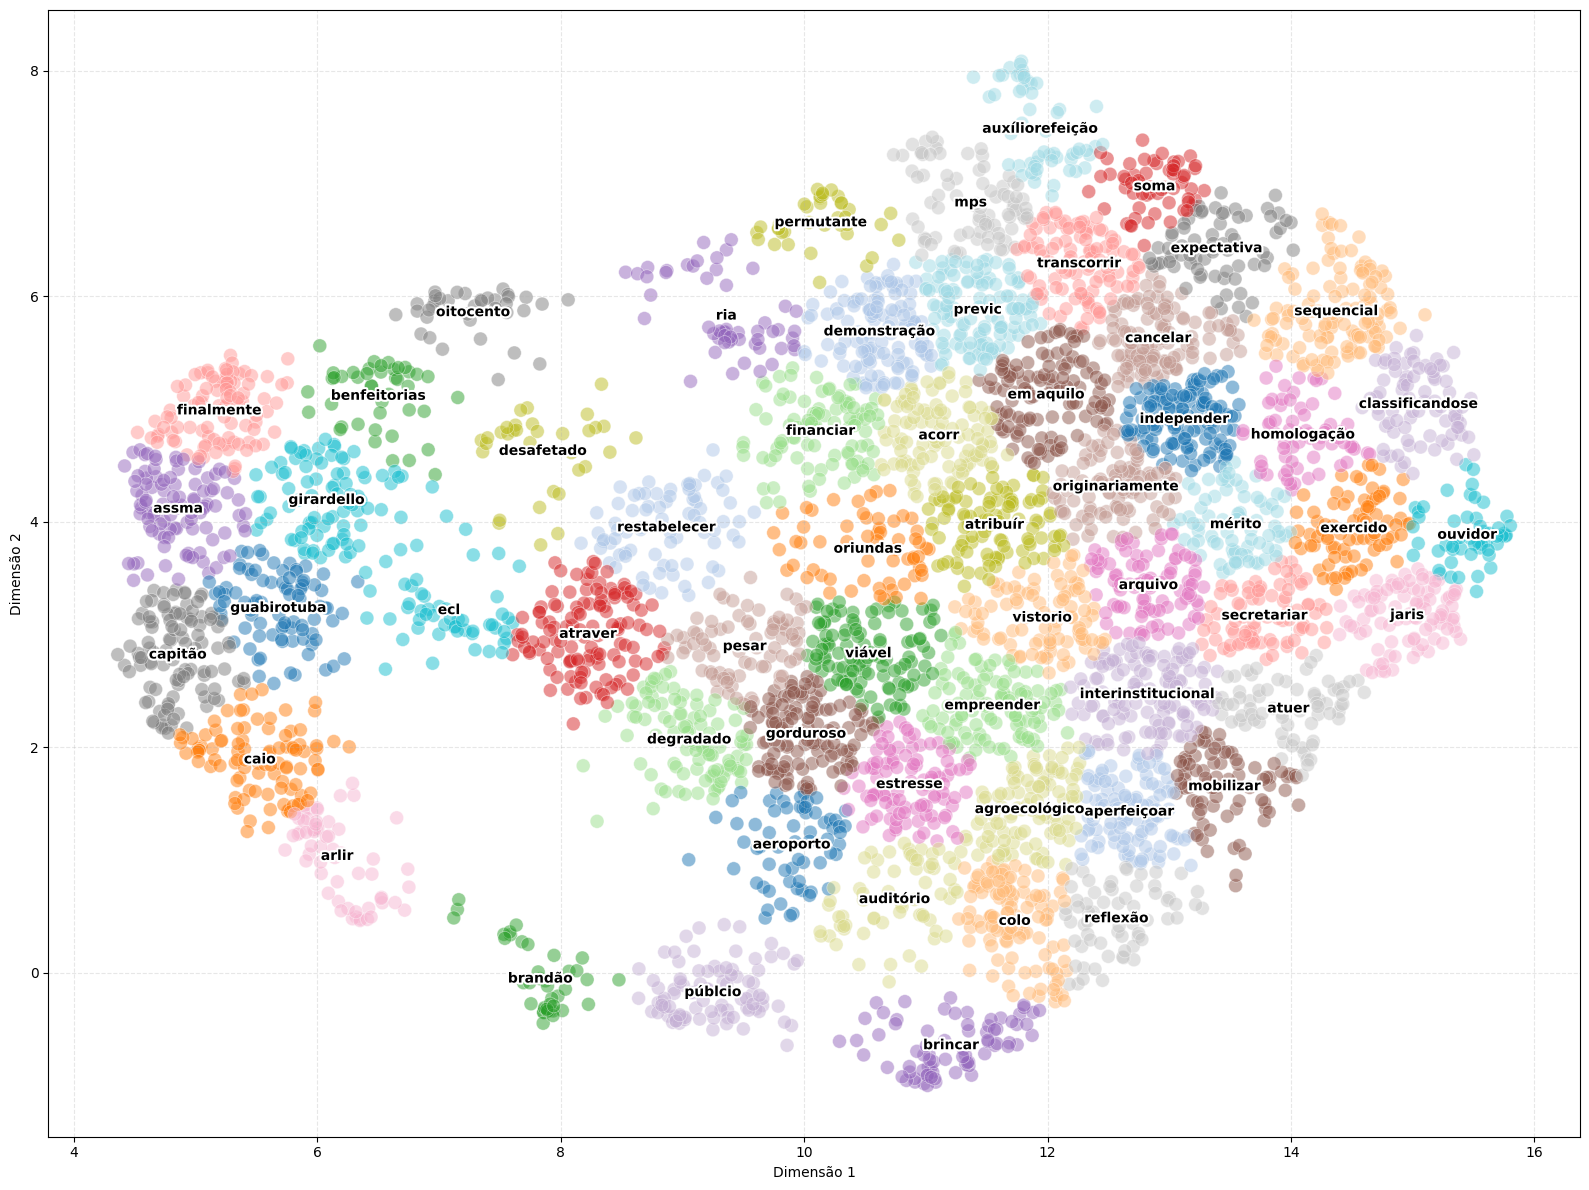

In [315]:
# UMAP com palavras representativas por cluster
plt.figure(figsize=(16, 12))

# pontos
plt.scatter(
    resultado_umap[:, 0],
    resultado_umap[:, 1],
    c=labels_umap,
    cmap='tab20',
    alpha=0.5,
    s=100,
    edgecolors='white',
    linewidth=0.5
)

clusters = np.unique(labels_umap)

for c in clusters:
    idx = np.where(labels_umap == c)[0]

    # centróide no espaço original
    centroide = vetores[idx].mean(axis=0)

    # palavra mais próxima do centróide
    distancias = cosine_distances(
        vetores[idx],
        centroide.reshape(1, -1)
    ).flatten()

    palavra_rep = palavras[idx[np.argmin(distancias)]]

    # posição média no UMAP
    x, y = resultado_umap[idx].mean(axis=0)

    plt.text(
        x, y,
        palavra_rep,
        fontsize=10,
        fontweight='bold',
        ha='center',
        va='center',
        path_effects=[
            pe.Stroke(linewidth=3, foreground='white'),
            pe.Normal()
        ]
    )

plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [316]:
dados_clusters = []

for c in np.unique(labels_umap):
    idx = np.where(labels_umap == c)[0]

    dados_clusters.append({
        "cluster": c,
        "tamanho": len(idx),
        "palavra_rep": palavras[idx[0]]
    })

df_clusters = pd.DataFrame(dados_clusters)
df_clusters.sort_values("tamanho", ascending=False).head(100)

cluster  tamanho      palavra_rep
1         1      128   administrativo
26       26      125          privado
19       19      125              uso
31       31      121          produto
11       11      121     procedimento
56       56      120          federal
5         5      118        executivo
29       29      117              ato
33       33      117            poder
9         9      113           pessoa
12       12      112        ambiental
3         3      110  desenvolvimento
16       16      108          pequeno
49       49      108          projeto
41       41      107             joão
22       22      105              ser
50       50      104            risco
15       15      101             área
47       47      101          serviço
24       24      101              rua
35       35      101           animal
20       20      100            metro
8         8       97          capital
17       17       97            ficar
34       34       96      responsável
10       10       95          empresa
39       39       94    representante
36       36       94    administração
27       27       91          público
53       53       87                b
2         2       86           bairro
44       44       82              lei
32       32       81          unidade
6         6       81         educação
28       28       81            cargo
21       21       80        municipal
30       30       80            saúde
4         4       78         critério
25       25       75        instituir
55       55       74          técnico
42       42       71         servidor
45       45       70       secretaria
37       37       67        funcional
43       43       65         realizar
51       51       64        esportivo
0         0       63         melhoria
38       38       61           título
7         7       61             ação
18       18       60            ativo
57       57       55         seguinte
23       23       54              brl
52       52       53             eixo
54       54       53          símbolo
13       13       43             lote
14       14       41             data
40       40       37            total
48       48       37         registro
46       46       33              bem

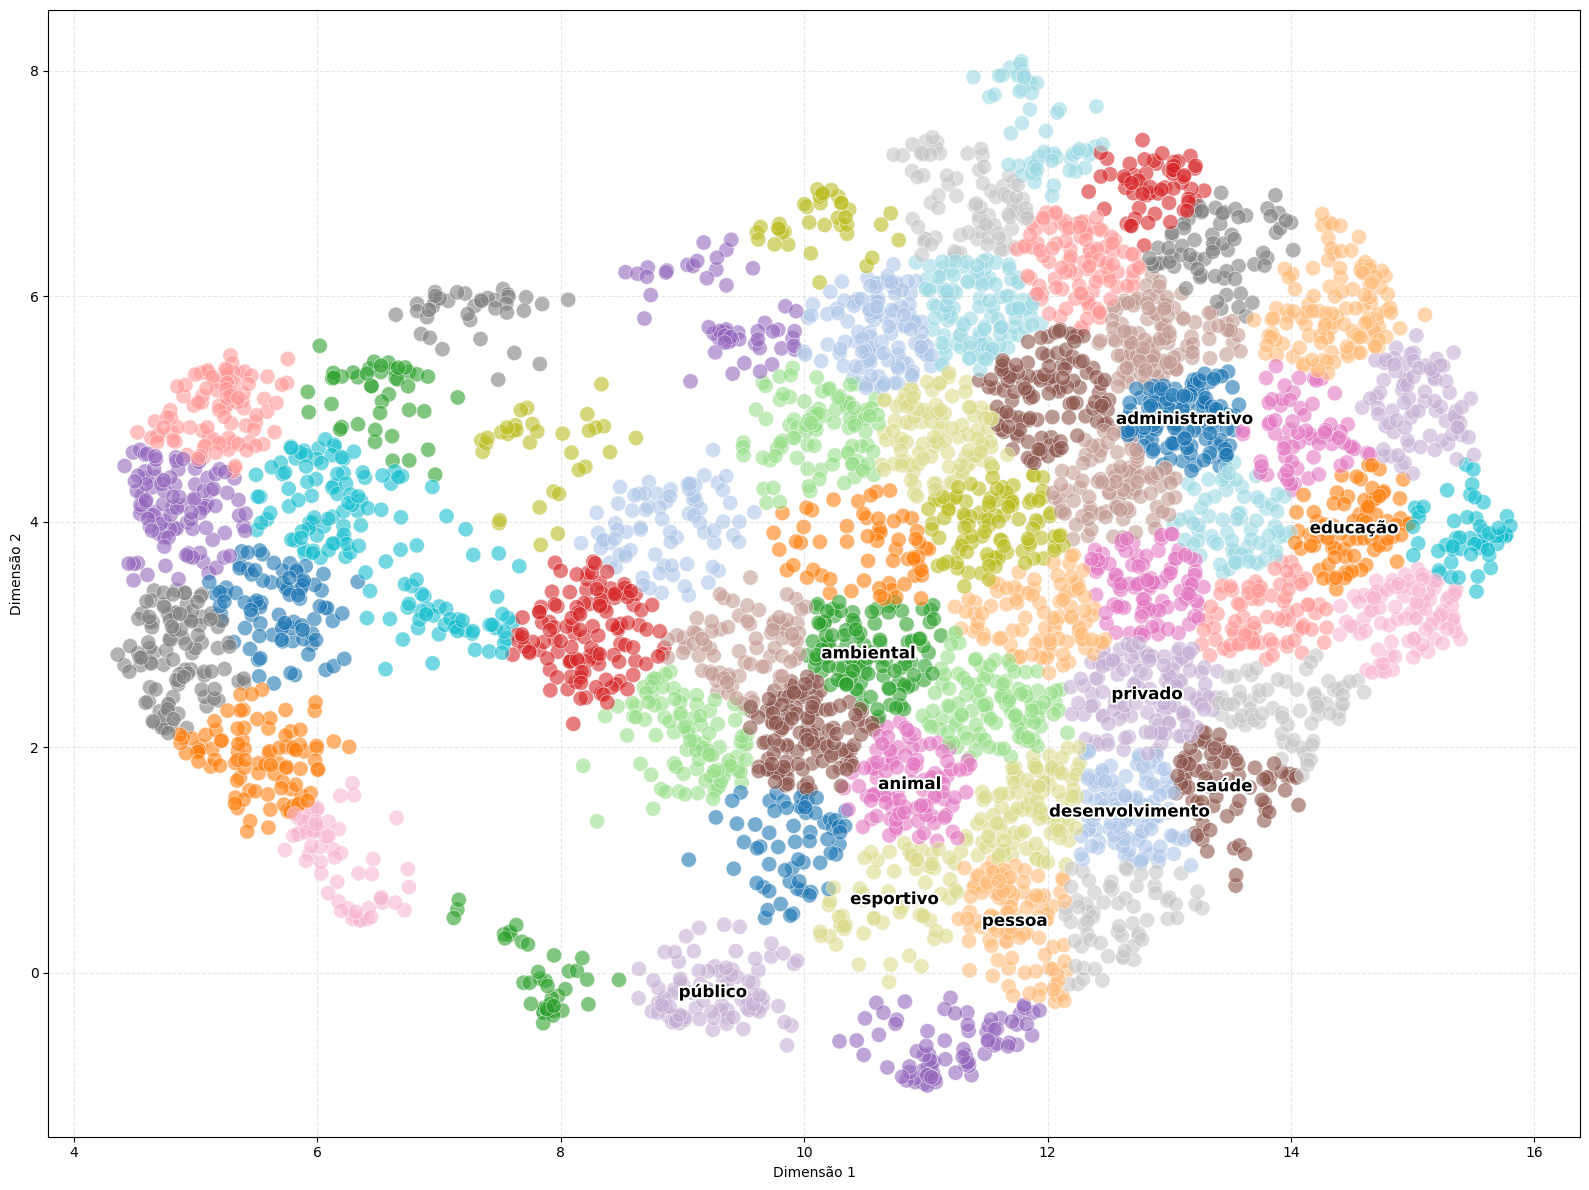

In [321]:
# UMAP com anotação apenas de clusters-chave
clusters_chave = [1, 3, 6, 9, 12, 26, 27, 30, 35, 51]

plt.figure(figsize=(16, 12))

plt.scatter(
    resultado_umap[:, 0],
    resultado_umap[:, 1],
    c=labels_umap,
    cmap='tab20',
    alpha=0.6,
    s=120,
    edgecolors='white',
    linewidth=0.5
)

for c in clusters_chave:
    idx = np.where(labels_umap == c)[0]

    x, y = resultado_umap[idx].mean(axis=0)

    # palavra representativa simples (primeira ou centróide)
    palavra_rep = palavras[idx[0]]

    plt.text(
        x, y,
        palavra_rep,
        fontsize=12,
        fontweight='bold',
        ha='center',
        va='center',
        path_effects=[
            pe.Stroke(linewidth=3, foreground='white'),
            pe.Normal()
        ]
    )

plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### 3.2 HDBSCAN

In [322]:
# HDBSCAN no espaço UMAP
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=5,
    metric='euclidean'
)

labels_hdbscan = clusterer.fit_predict(resultado_umap)

# Número de clusters (excluindo ruído)
clusters_validos = set(labels_hdbscan)
clusters_validos.discard(-1)

print(f"Número de clusters encontrados (HDBSCAN): {len(clusters_validos)}")
print(f"Pontos considerados ruído: {(labels_hdbscan == -1).sum()}")

Número de clusters encontrados (HDBSCAN): 18
Pontos considerados ruído: 392


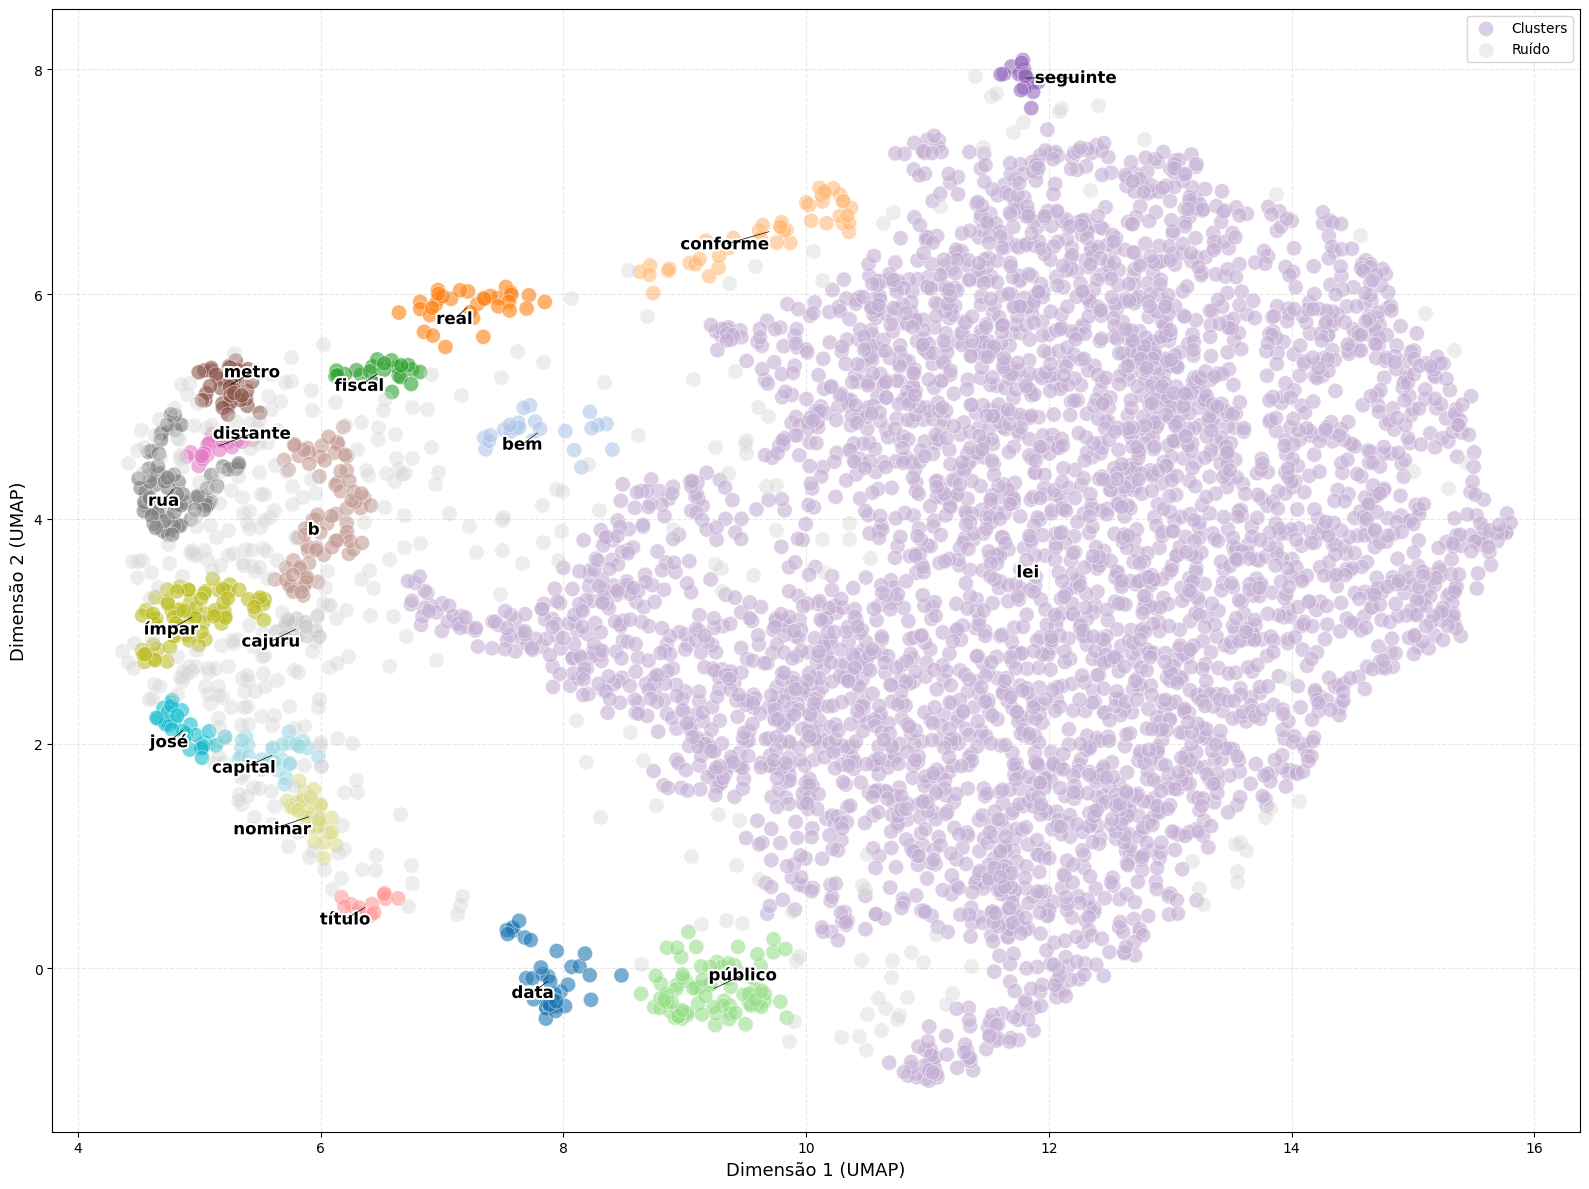

In [323]:
plt.figure(figsize=(16, 12))

# Scatter dos clusters válidos (labels != -1)
scatter = plt.scatter(
    resultado_umap[labels_hdbscan != -1, 0],
    resultado_umap[labels_hdbscan != -1, 1],
    c=labels_hdbscan[labels_hdbscan != -1],
    cmap='tab20',
    alpha=0.6,
    s=120,
    edgecolors='white',
    linewidth=0.5,
    label='Clusters'
)

# Scatter do ruído
plt.scatter(
    resultado_umap[labels_hdbscan == -1, 0],
    resultado_umap[labels_hdbscan == -1, 1],
    c='lightgray',
    alpha=0.4,
    s=120,
    edgecolors='white',
    linewidth=0.5,
    label='Ruído'
)

texts = []

# Anotação por clusters válidos
for c in clusters_validos:
    idx = np.where(labels_hdbscan == c)[0]
    if len(idx) == 0:
        continue

    centro_cluster = resultado_umap[idx].mean(axis=0)
    palavra_rep = palavras[idx[0]]

    txt = plt.text(
        centro_cluster[0],
        centro_cluster[1],
        palavra_rep,
        fontsize=12,
        fontweight='bold',
        color="black",
        ha="center",
        va="center",
        path_effects=[
            pe.Stroke(linewidth=3, foreground="white"),
            pe.Normal()
        ]
    )
    texts.append(txt)

adjust_text(
    texts,
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_text=(0.5, 0.5),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5)
)

plt.xlabel('Dimensão 1 (UMAP)', fontsize=13)
plt.ylabel('Dimensão 2 (UMAP)', fontsize=13)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Salvando resultados finais
np.save("results/umap_2d.npy", resultado_umap)
np.save("results/labels_kmeans.npy", clusters)
np.save("results/labels_hdbscan.npy", labels_hdbscan)

##### End of the code